# The Third Circle: Tree-Based Methods, Part One 
## Binary Classification 

<br/>
Jiří Fejlek

2026-01-07
<br/>


## Table of Contents

- [Heart Disease Datasets (Cleveland, Hungary, Switzerland, and the VA Long Beach)](#heart)
- [Classification Trees](#class_tree-heart)
- [Bagging](#bagging-heart)
    - [Bagging of Classification Trees](#simple-bagging-heart)
    - [Random Forests](#random_forests-heart)
- [Boosting](#boosting-heart)
    - [AdaBoost](#adaboost-heart)
    - [GBM Algorithm](#gradient_boosting-heart)
    - [XGBoost](#xgboost-heart)
        - [Categorical Features](#categorical-heart)
    - [LightGBM](#lightgbm-heart)
    - [CatBoost](#catboost-heart)
- [Model Stacking](#model-stacking)
- [References](#references)

In the Third Circle, we will focus on tree-based methods. Tree-based methods are highly flexible and widely popular models for both classification and regression tasks, often offering superior performance compared to other approaches [[1](#1), [2](#2)].

## Heart Disease Datasets (Cleveland, Hungary, Switzerland, and the VA Long Beach) <a class="anchor" id="heart"></a>

We will continue to use the dataset from the Second Circle Part One obtained from https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data, based on four studies (Cleveland Clinic in Cleveland, Ohio; Hungarian Institute of Cardiology in Budapest, Hungary; Veterans Administration Medical Center in Long Beach, California; University Hospitals in Zurich and Basel, Switzerland) [[3](#3)]. The goal is to distinguish the patients with heart disease. The variables in the dataset are as follows.

* **age** 
* **sex** - age (at the time of examination)
* **dataset** - Cleveland, Hungary, Switzerland, and the VA Long Beach
* **cp** - chest pain type (typical angina, atypical angina, non-anginal, asymptomatic)
* **trestbps** - resting blood pressure in mm Hg 
* **chol** - serum cholesterol in mg/dl 
* **fbs** - fasting blood sugar > 120 mg/dl (True/False)
* **restecg** - resting electrocardiographic results (normal, ST-T abnormality, LV hypertrophy)
* **thalach** - maximum heart rate achieved
* **exang** -  exercise-induced angina (True/ False)
* **oldpeak** - ST depression induced by exercise relative to rest
* **slope** -  the slope of the peak exercise ST segment (flat, downsloping, upsloping)
* **ca** - number of major vessels (0-3) colored by fluoroscopy
* **thal** - thallium heart scan defect (normal, fixed defect, reversible defect)
* **num** -  diagnosis of heart disease (0 = no heart disease; 1,2,3,4 = stages of heart disease)

Let us load the dataset, and prepare the data for analysis, repeating the steps we did in the Second Circle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import KFold
from missforest import MissForest
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score, log_loss, brier_score_loss, f1_score, matthews_corrcoef, cohen_kappa_score)
from sklearn.calibration import calibration_curve 

np.set_printoptions(legacy='1.25')

In [2]:
# load the dataset
heart = pd.read_csv('C:/Users/elini/Desktop/nine circles 2/heart_disease_uci.csv')

# replace 0 with NaN and remove duplicates
heart.loc[heart['chol'] == 0,'chol'] = np.nan
heart.loc[heart['trestbps'] == 0,'trestbps'] = np.nan
heart_red = heart.drop(axis = 0, index = [405,907]).reset_index()

# prepare for missForrest imputation
heart_imp = heart_red[['age','sex','dataset','cp','trestbps','chol','fbs','restecg','thalch','exang','oldpeak','slope', 'thal']].copy()
heart_imp['sex'] = heart_imp['sex'].map({'Male': 1, 'Female': 0})
heart_imp['dataset'] = heart_imp['dataset'].map({'Cleveland': 0, 'Hungary': 1, 'Switzerland': 2, 'VA Long Beach': 3})
heart_imp['cp'] = heart_imp['cp'].map({'asymptomatic': 0, 'typical angina': 1, 'atypical angina': 2, 'non-anginal': 3})
heart_imp['fbs'] = heart_imp['fbs'].map({True: 1, False: 0})
heart_imp['restecg'] = heart_imp['restecg'].map({'normal': 0, 'lv hypertrophy': 1, 'st-t abnormality': 2})
heart_imp['exang'] = heart_imp['exang'].map({True: 1, False: 0})
heart_imp['slope'] = heart_imp['slope'].map({'flat': 0, 'downsloping': 1, 'upsloping': 2})
heart_imp['thal'] = heart_imp['thal'].map({'normal': 0, 'reversable defect': 1, 'fixed defect': 2})

categorical_variables_heart = ['sex','dataset','cp','fbs','restecg','exang','slope','thal']

# imputation
np.random.seed(123)
MissForest_imputation = MissForest(categorical=categorical_variables_heart)
MissForest_imputation._verbose = 0

MissForest_imputation.fit(x = heart_imp)
heart_imp_MissForest = heart_imp.copy()

heart_imp_MissForest =  MissForest_imputation.transform(x = heart_imp)

# final dataset
heart_final = heart_imp_MissForest.copy()
heart_final['heart_disease'] = (heart['num'] > 0).astype(int) 
heart_final['dataset'] = heart_final['dataset'].map({0: 'Clv', 1: 'Hun', 2: 'Swit', 3: 'VA'})
heart_final['cp'] = heart_final['cp'].map({0: 'asymp', 1: 'typ', 2: 'atyp', 3: 'nonang'})
heart_final['restecg'] = heart_final['restecg'].map({0: 'normal', 1: 'hypertrophy', 2: 'stt'})
heart_final['slope'] = heart_final['slope'].map({0: 'flat', 1: 'down', 2: 'up'})
heart_final['thal'] = heart_final['thal'].map({0: 'normal', 1: 'rev', 2: 'fixed'})

heart_final = pd.concat([heart_final,pd.get_dummies(heart_final[['cp','restecg','slope','thal']], dtype=int)], axis=1)
heart_final = heart_final[['age','sex','cp_typ','cp_atyp','cp_nonang','restecg_hypertrophy','restecg_stt',\
                           'thalch','exang','trestbps','oldpeak','fbs','chol','slope_down','slope_up','thal_rev','thal_fixed','heart_disease']]

## Classification Trees <a class="anchor" id="class_tree-heart"></a>

A classification is a simple model based on repeated splitting of the feature space, represented by a decision *tree* (a graph); each node of the tree, except for the terminal nodes (so-called leaves), corresponds to a split of the feature space. These individual splits are considered to be of a very simple form: $\{X \mid X_j < x\}$ vs. $\{X \mid X_j \geq x\}$. However, repeated splitting allows for obtaining very flexible individual regions in the form of *boxes* that cover the entire feature space. 

As for the classification itself, once the partitioning is complete, each leaf/box $R_j$ contains one or more observations from the training set. The predicted class for all $x \in R_j$ is based on the most commonly occurring class among training data observations in $R_j$. The predicted probabilities are set as proportions. Overall, we observe that the resulting model has the form of an *additive* model
$$ f(x) = \sum_j c_j I(x \in R_j),$$
where $I$ are indicator functions and $c_j$ are constants based on class proportions of training data in $R_j$. 

Since optimizing some overall classification metric of the classification tree model would be computationally intractable, partitions are learned from the training data by minimizing *impurity* measure of the resulting boxes: popular choices are cross-entropy (aka log-loss)  $-\sum_k \hat p_k\text{log } \hat p_k$ and the Gini index $\sum_k \hat p_k (1- \hat p_k)$, where $\hat p_k$ denotes the predicted probability of the $k$th class in the box (i.e., the proportion of the $k$th class in the resulting box). Both of these metrics are minimized for some $\hat p_k = 1$ (the box consists of a training sample of only one class) and maximized for a uniform distribution (corresponding to purely random predictions, i.e., all classes are uniformly represented in the box). The learning algorithm is usually *greedy*: at each step, it finds the split that minimizes the weighted (by the number of samples in the box) sum of impurities of the resulting two boxes [[4](#4), [5](#5)]. 

Let us fit a simple classification tree using the Gini index as the impurity measure on our dataset.

In [3]:
from sklearn.tree import DecisionTreeClassifier

class_tree_heart = DecisionTreeClassifier(criterion='gini',splitter='best') 
class_tree_fit_heart = class_tree_heart.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease']) 

Since we did not set any limits on splits nor did we introduce some cost for splitting the data, the algorithm continues splitting the dataset until every region consists solely of data from the same class, i.e., the model perfectly separates the training dataset.

In [4]:
obs_heart = heart_final['heart_disease'].to_numpy() 
pred_class_tree_heart = class_tree_fit_heart.predict(X = heart_final.iloc[:,range(0,17)])

accuracy_score(obs_heart,pred_class_tree_heart)

1.0

Consequently, all predicted probabilities are 0 and 1.

In [5]:
pred_prob_class_tree_heart = class_tree_fit_heart.predict_proba(X = heart_final.iloc[:,range(0,17)])
pred_prob_class_tree_heart

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

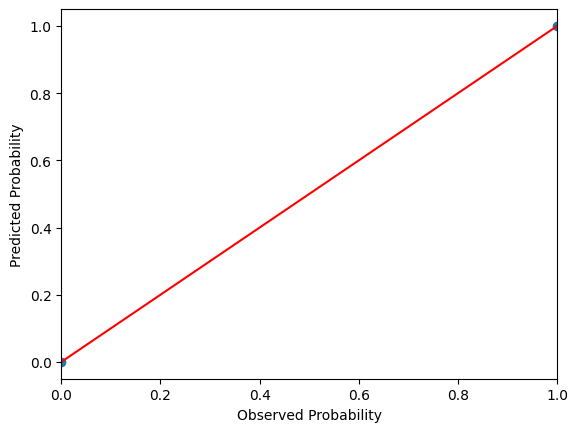

In [6]:
prob_true_class_tree_heart, prob_pred_class_tree_heart = calibration_curve(obs_heart,pred_prob_class_tree_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_class_tree_heart,prob_pred_class_tree_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

Let us investigate how this model would generalize to new data via cross-validation.

In [7]:
from sklearn.model_selection import cross_validate
class_tree_scores_heart  = cross_validate(class_tree_heart, X=heart_final.iloc[:,range(0,17)], \
                                          y = heart_final['heart_disease'], scoring={'acc': 'accuracy','brier': 'neg_brier_score','auc': 'roc_auc'},cv=10)

In [8]:
# Accuracy
print(class_tree_scores_heart['test_acc']) 

[0.63043478 0.60869565 0.57608696 0.65217391 0.67391304 0.7826087
 0.61956522 0.69565217 0.61538462 0.56043956]


In [9]:
class_tree_scores_heart['test_acc'].mean()

0.6414954610606785

In [10]:
# Brier score
print(class_tree_scores_heart['test_brier']) 

[-0.36956522 -0.39130435 -0.42391304 -0.34782609 -0.32608696 -0.2173913
 -0.38043478 -0.30434783 -0.38461538 -0.43956044]


In [11]:
class_tree_scores_heart['test_brier'].mean()

-0.35850453893932155

In [12]:
# ROC AUC
print(class_tree_scores_heart['test_auc']) 

[0.62601626 0.61119082 0.57938785 0.6504065  0.68197035 0.79435677
 0.62816834 0.69201339 0.58853659 0.52097561]


In [13]:
class_tree_scores_heart['test_auc'].mean()

0.6373022477283596

We observe that performance significantly degraded; the classifier is almost as bad as a random classifier for some validation samples (the Brier score is actually worse than 0.25; ROC AUC and accuracy are a bit better than 0.5). We clearly need to control the number of splits to obtain a model that generalizes well to new data. 

We could consider straightforward hyperparameters that limit the size of the tree such as *max_depth* (i.e., the maximum length of a path from the leaf to the root), *min_samples_leaf* (the minimum number of samples in a single leaf) and *min_samples_split* (the minimum number of samples to be split). Alternatively, we can consider *cost-complexity pruning*. For a given classification tree, we define a complexity criterion
$$C_\alpha = \sum_{k = 1}^{|R|} Q(R_k) + \alpha |R|,$$
where $Q(R_k)$ are weighted impurities of the classification boxes, $|R|$ is the number of boxes, and $\alpha$ is a tuning parameter that governs the balance between overall impurity and complexity. The pruning is performed after the tree is fitted. The goal is to find a subtree of the original classification tree that minimizes the value of the complexity criterion. We should note that this optimal subtree can be found quite efficiently using *weakest link pruning* [[5](#5)]. 

Let us fit decision trees with cost-complexity pruning. As one would expect, we will estimate the optimal value of the tuning parameter $\alpha$ via cross-validation (we will use log-loss for evaluating the performance). 

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

np.random.seed(123)

parameters = {'criterion':['gini'], 'splitter':['best'],'ccp_alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)

class_tree_gridcv_heart = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=parameters, scoring = 'neg_log_loss', cv = cv)
class_tree_gridcv_heart_fit = class_tree_gridcv_heart.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
class_tree_gridcv_heart_fit.best_params_

{'ccp_alpha': 0.01, 'criterion': 'gini', 'splitter': 'best'}

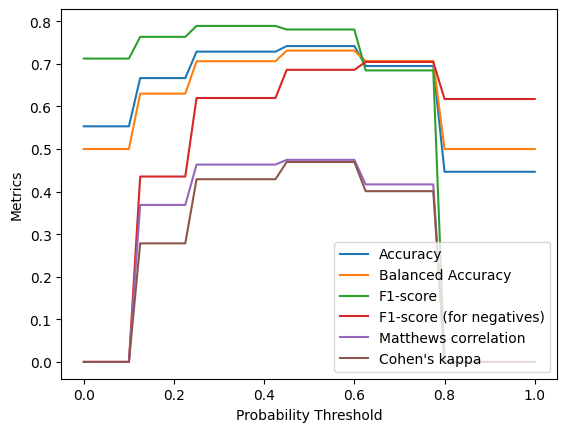

In [15]:
pred_prob_class_tree_gridcv_heart = class_tree_gridcv_heart_fit.predict_proba(X = heart_final.iloc[:,range(0,17)])

accuracy_scores_tree_gridcv_heart = np.zeros(41)
balanced_accuracy_scores_tree_gridcv_heart = np.zeros(41)
f1_scores_tree_gridcv_heart = np.zeros(41)
f1_scores_neg_tree_gridcv_heart = np.zeros(41)
matthews_corrcoefs_tree_gridcv_heart = np.zeros(41)
cohen_kappa_scores_tree_gridcv_heart = np.zeros(41)
accuracy_thresholds = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_tree_gridcv_heart[k] = accuracy_score(obs_heart,(pred_prob_class_tree_gridcv_heart[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_tree_gridcv_heart[k] = balanced_accuracy_score(obs_heart,(pred_prob_class_tree_gridcv_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_tree_gridcv_heart[k] = f1_score(obs_heart,(pred_prob_class_tree_gridcv_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_tree_gridcv_heart[k] = f1_score(obs_heart,(pred_prob_class_tree_gridcv_heart[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_tree_gridcv_heart[k] = matthews_corrcoef(obs_heart,(pred_prob_class_tree_gridcv_heart[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_tree_gridcv_heart[k] = cohen_kappa_score(obs_heart,(pred_prob_class_tree_gridcv_heart[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_tree_gridcv_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_tree_gridcv_heart)
plt.plot(accuracy_thresholds,f1_scores_tree_gridcv_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_tree_gridcv_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_tree_gridcv_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_tree_gridcv_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [16]:
roc_auc_score(obs_heart,pred_prob_class_tree_gridcv_heart[:,1])

0.7852842327635875

In [17]:
brier_score_loss(obs_heart,pred_prob_class_tree_gridcv_heart[:,1])

0.1795991510867093

In [18]:
log_loss(obs_heart,pred_prob_class_tree_gridcv_heart[:,1])

0.5398722430653276

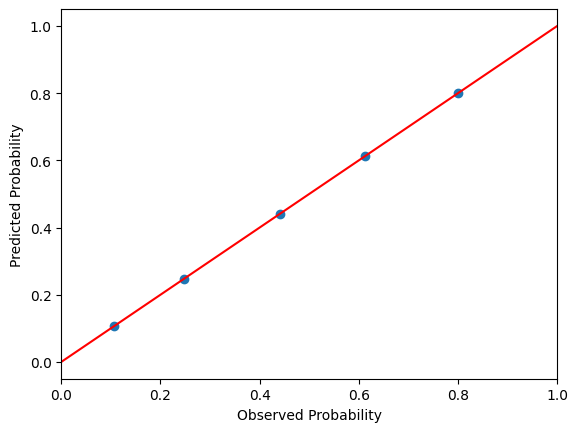

In [19]:
prob_true_class_tree_gridcv_heart, prob_pred_class_tree_gridcv_heart = calibration_curve(obs_heart,pred_prob_class_tree_gridcv_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_class_tree_gridcv_heart,prob_pred_class_tree_gridcv_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

We observe that the tree classifier with cost-complexity pruning seems to be a much more reasonable model. Let us cross-validate the discrimination metrics for the best tree-based classifier we have found.

In [20]:
# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_class_tree =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]

        class_tree_heart_new = DecisionTreeClassifier(criterion='gini',splitter='best',ccp_alpha = 0.01)
        class_tree_heart_fit_new = class_tree_heart_new.fit(X = heart_train.iloc[:,range(0,17)], y = heart_train['heart_disease'])
        pred_tree_heart_new = class_tree_heart_fit_new.predict(X = heart_test.iloc[:,range(0,17)])
        pred_prob_tree_heart_new = class_tree_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,17)])
        logitp_tree_heart_new = np.log(np.clip(pred_prob_tree_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_tree_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_class_tree.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_tree_heart_new)
        metrics_cv_heart_class_tree.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_tree_heart_new)
        metrics_cv_heart_class_tree.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_tree_heart_new[:,1])
        metrics_cv_heart_class_tree.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_tree_heart_new[:,1])
        metrics_cv_heart_class_tree.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_tree_heart_new[:,1])
        metrics_cv_heart_class_tree.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_tree_heart_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1

metrics_cv_heart_class_tree.mean()

Balanced Accuracy       0.707592
Matthews Correlation    0.434391
AUC                     0.756452
Brier score               0.1944
Log loss                0.580454
Calibration             0.841902
dtype: object

The regularization via cost-complexity pruning worked indeed; the cross-validated metrics did not drop as much. The model is also somewhat well-calibrated. However, the performance of the tree classifier is still significantly worse than any model we considered in the first part. This result seems to be in stark contrast to our introduction, in which we claimed that tree-based classifiers are often the best-performing ones, period. It turns out that while a single classification tree is usually not that good, many of them stacked together work exceptionally well. 

## Bagging <a class="anchor" id="bagging-heart"></a>

The classification trees suffer from *high variance*: slight alterations to the data will often lead to vastly different classification trees, making these classifiers somewhat unstable in performance. Bagging, or *bootstrap aggregation*, averages predictions from models trained on bootstrap resamples, thereby reducing prediction variance and hopefully leading to better predictions overall. 

### Bagging of Classification Trees <a class="anchor" id="simple-bagging-heart"></a>

The bagging method can be used for any classification/regression model, but it is particularly useful for decision trees. Lastly, we should note that when bagging, the trees are usually used unpruned [[4](#4),[5](#5)].

In [21]:
from sklearn.ensemble import BaggingClassifier
bagging_trees_heart = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='gini',splitter='best'), n_estimators = 100, random_state = 123, oob_score = True)
bagging_trees_heart_fit = bagging_trees_heart.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])

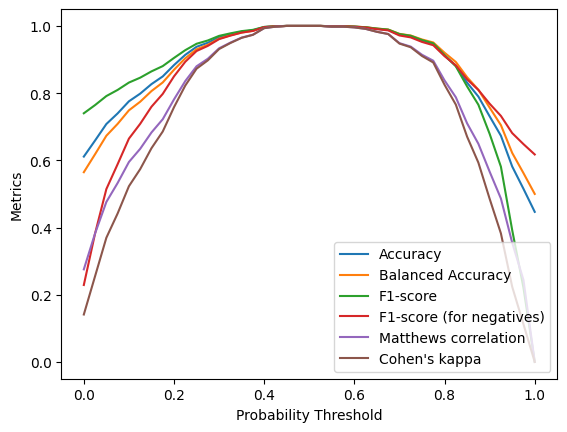

In [22]:
pred_prob_bagging_trees_heart = bagging_trees_heart_fit.predict_proba(heart_final.iloc[:,range(0,17)])

accuracy_scores_bagging_trees_heart = np.zeros(41)
balanced_accuracy_scores_bagging_trees_heart = np.zeros(41)
f1_scores_bagging_trees_heart = np.zeros(41)
f1_scores_neg_bagging_trees_heart = np.zeros(41)
matthews_corrcoefs_bagging_trees_heart = np.zeros(41)
cohen_kappa_scores_bagging_trees_heart = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_bagging_trees_heart[k] = accuracy_score(obs_heart,(pred_prob_bagging_trees_heart[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_bagging_trees_heart[k] = balanced_accuracy_score(obs_heart,(pred_prob_bagging_trees_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_bagging_trees_heart[k] = f1_score(obs_heart,(pred_prob_bagging_trees_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_bagging_trees_heart[k] = f1_score(obs_heart,(pred_prob_bagging_trees_heart[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_bagging_trees_heart[k] = matthews_corrcoef(obs_heart,(pred_prob_bagging_trees_heart[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_bagging_trees_heart[k] = cohen_kappa_score(obs_heart,(pred_prob_bagging_trees_heart[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_bagging_trees_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_bagging_trees_heart)
plt.plot(accuracy_thresholds,f1_scores_bagging_trees_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_bagging_trees_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_bagging_trees_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_bagging_trees_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [23]:
roc_auc_score(obs_heart,pred_prob_bagging_trees_heart[:,1])

1.0

In [24]:
brier_score_loss(obs_heart,pred_prob_bagging_trees_heart[:,1])

0.02363202614379085

In [25]:
log_loss(obs_heart,pred_prob_bagging_trees_heart[:,1])

0.13366002356276627

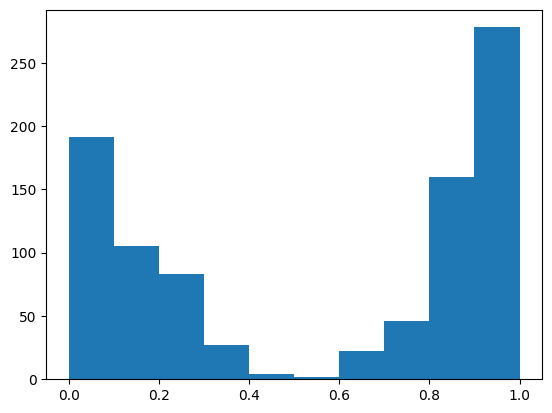

In [26]:
plt.hist(pred_prob_bagging_trees_heart[:,1]);

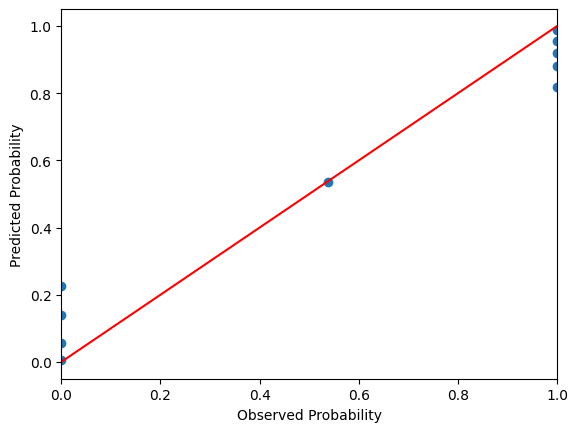

In [27]:
prob_true_bagging_trees_heart, prob_pred_bagging_trees_heart = calibration_curve(obs_heart,pred_prob_bagging_trees_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_bagging_trees_heart,prob_pred_bagging_trees_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

Similar to our original classification trees, predictions on the training set seem perfect. The probability predictions are still mainly concentrated near 0 and 1.

One advantage of bagging is that we can obtain the so-called *out-of-bag* error. The bootstrap resamples contain, on average, about only two-thirds of the data. Consequently, we can estimate the prediction error of a given observation using only, on average, one-third of the trees that were not trained using this observation.

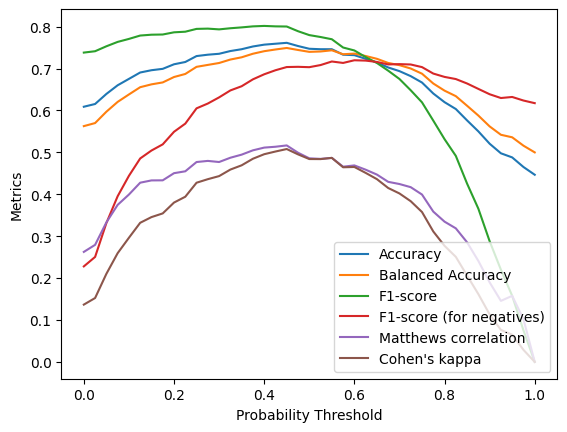

In [28]:
accuracy_scores_bagging_trees_oob_heart = np.zeros(41)
balanced_accuracy_scores_bagging_trees_oob_heart = np.zeros(41)
f1_scores_bagging_trees_oob_heart = np.zeros(41)
f1_scores_neg_bagging_trees_oob_heart = np.zeros(41)
matthews_corrcoefs_bagging_trees_oob_heart = np.zeros(41)
cohen_kappa_scores_bagging_trees_oob_heart = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_bagging_trees_oob_heart[k] = accuracy_score(obs_heart,(bagging_trees_heart_fit.oob_decision_function_[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_bagging_trees_oob_heart[k] = balanced_accuracy_score(obs_heart,(bagging_trees_heart_fit.oob_decision_function_[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_bagging_trees_oob_heart[k] = f1_score(obs_heart,(bagging_trees_heart_fit.oob_decision_function_[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_bagging_trees_oob_heart[k] = f1_score(obs_heart,(bagging_trees_heart_fit.oob_decision_function_[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_bagging_trees_oob_heart[k] = matthews_corrcoef(obs_heart,(bagging_trees_heart_fit.oob_decision_function_[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_bagging_trees_oob_heart[k] = cohen_kappa_score(obs_heart,(bagging_trees_heart_fit.oob_decision_function_[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_bagging_trees_oob_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_bagging_trees_oob_heart)
plt.plot(accuracy_thresholds,f1_scores_bagging_trees_oob_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_bagging_trees_oob_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_bagging_trees_oob_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_bagging_trees_oob_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [29]:
roc_auc_score(obs_heart,bagging_trees_heart_fit.oob_decision_function_[:,1])

0.8134266372191281

In [30]:
brier_score_loss(obs_heart,bagging_trees_heart_fit.oob_decision_function_ [:,1])

0.17197418550034305

In [31]:
log_loss(obs_heart,bagging_trees_heart_fit.oob_decision_function_ [:,1])

0.6660595072792734

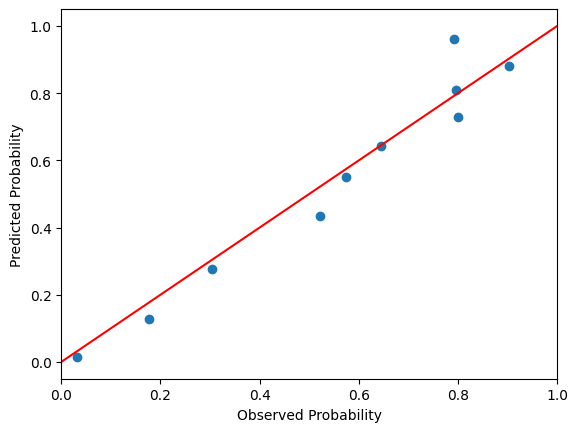

In [32]:
prob_true_bagging_trees_heart, prob_pred_bagging_trees_heart = calibration_curve(obs_heart,bagging_trees_heart_fit.oob_decision_function_[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_bagging_trees_heart,prob_pred_bagging_trees_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

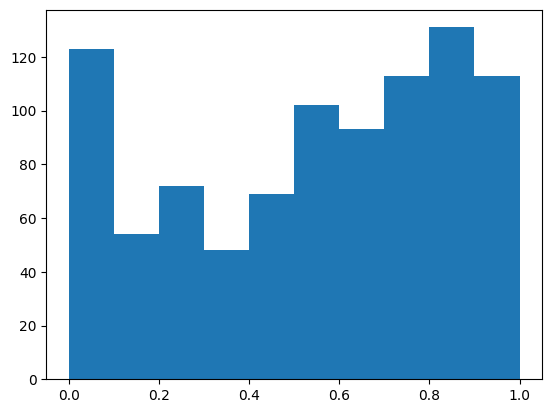

In [33]:
plt.hist(bagging_trees_heart_fit.oob_decision_function_[:,1]);

We observe that out-of-bag predictions are pretty reasonable. The predicted out-of-bag probabilities also seem reasonably well calibrated. It can be shown that the out-of-bag scores that we computed converge to the leave-one-out cross-validation [[4](#4),[5](#5)]. 

In [34]:
# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_bagging_trees =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score','Log Loss','Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]


        bagging_trees_heart_new = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='gini',splitter='best'),n_estimators=100, oob_score = True)
        bagging_trees_heart_fit_new = bagging_trees_heart_new.fit(X = heart_train.iloc[:,range(0,17)], y = heart_train['heart_disease'])
        pred_bagging_trees_heart_new = bagging_trees_heart_fit_new.predict(X = heart_test.iloc[:,range(0,17)])
        pred_prob_bagging_trees_heart_new = bagging_trees_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,17)])
        logitp_bagging_trees_new = np.log(np.clip(pred_prob_bagging_trees_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_bagging_trees_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_bagging_trees.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_bagging_trees_heart_new)
        metrics_cv_heart_bagging_trees.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_bagging_trees_heart_new)
        metrics_cv_heart_bagging_trees.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_bagging_trees_heart_new[:,1])
        metrics_cv_heart_bagging_trees.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_bagging_trees_heart_new[:,1])
        metrics_cv_heart_bagging_trees.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_bagging_trees_heart_new[:,1])
        metrics_cv_heart_bagging_trees.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_bagging_trees_new).assign(const=1)).fit(disp=0).params.iloc[0]
        
        k = k + 1

metrics_cv_heart_bagging_trees.mean()

Balanced Accuracy       0.752264
Matthews Correlation    0.511093
AUC                       0.8173
Brier score             0.170192
Log Loss                0.550682
Calibration             0.835384
dtype: object

Indeed, the prediction metrics (AUC and Brier score especially) are pretty similar to the out-of-bag results. Hence, by using the out-of-bag metrics to optimize parameter values, we can save a significant computational time. 

Overall, we finally obtained a classifier that performs just slightly worse than the methods we considered in the first part. But we can do even better.

### Random Forests <a class="anchor" id="random_forests-heart"></a>

Random forests [[6](#6)] are a further improvement over bagged trees, aiming to increase the variability between individual classifier trees. The core idea is based on the observation that averaging is most effective at reducing variance when the random variables being averaged are independent. Hence, a random forest aims to *decorrelate* the bagged classification trees. 

In a random forest, only a random subset of predictors is considered at each split when classification trees are being built. This modification ensures that each tree classifier does not use the same subset of powerful predictors, which makes the classification trees somewhat similar and thus correlated [[4](#4), [5](#5), [6](#6)]. 

We can fit a random forest classifier using *RandomForestClassifier*. The number of features considered in each split is determined by *max_features*.

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_heart = RandomForestClassifier(n_estimators = 100, criterion='gini', max_features='sqrt', random_state=123, oob_score = True)
forest_heart_fit = forest_heart.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease']) 

We will evaluate the model using the out-of-bag predictions right away.

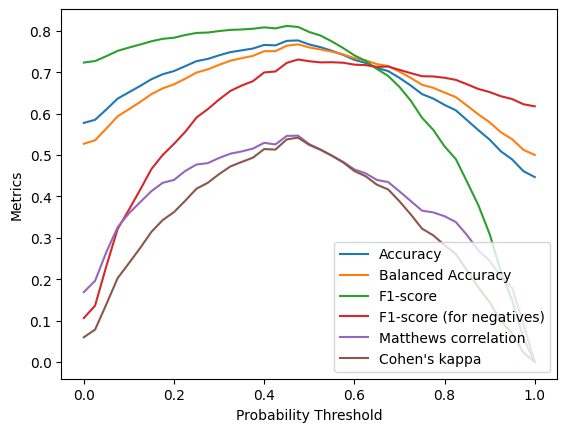

In [36]:
pred_prob_forest_heart = forest_heart_fit.oob_decision_function_

accuracy_scores_forest_heart = np.zeros(41)
balanced_accuracy_scores_forest_heart = np.zeros(41)
f1_scores_forest_heart = np.zeros(41)
f1_scores_neg_forest_heart = np.zeros(41)
matthews_corrcoefs_forest_heart = np.zeros(41)
cohen_kappa_scores_forest_heart = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_forest_heart[k] = accuracy_score(obs_heart,(pred_prob_forest_heart[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_forest_heart[k] = balanced_accuracy_score(obs_heart,(pred_prob_forest_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_forest_heart[k] = f1_score(obs_heart,(pred_prob_forest_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_forest_heart[k] = f1_score(obs_heart,(pred_prob_forest_heart[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_forest_heart[k] = matthews_corrcoef(obs_heart,(pred_prob_forest_heart[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_forest_heart[k] = cohen_kappa_score(obs_heart,(pred_prob_forest_heart[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_forest_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_forest_heart)
plt.plot(accuracy_thresholds,f1_scores_forest_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_forest_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_forest_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_forest_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [37]:
roc_auc_score(obs_heart,pred_prob_forest_heart[:,1])

0.8239773381985788

In [38]:
brier_score_loss(obs_heart,pred_prob_forest_heart[:,1])

0.16635470841344685

In [39]:
log_loss(obs_heart,pred_prob_forest_heart[:,1])

0.6091594450994919

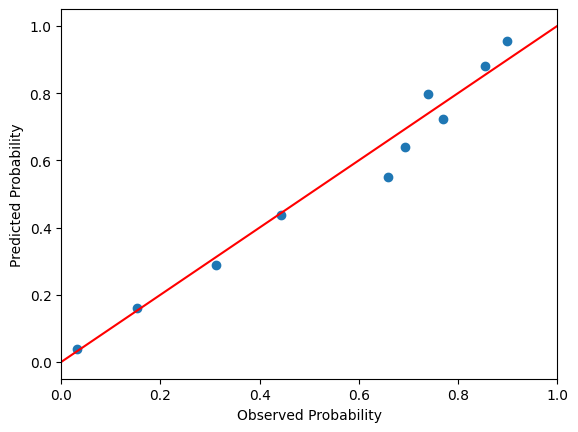

In [40]:
prob_true_forest_heart, prob_pred_forest_heart = calibration_curve(obs_heart,pred_prob_forest_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_forest_heart,prob_pred_forest_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

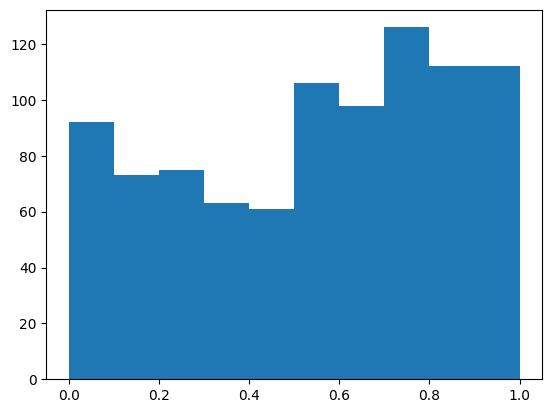

In [41]:
plt.hist(pred_prob_forest_heart[:,1]);

It seems that random forests improved the prediction metrics slightly compared to bagging. To wrap up the bootstrap aggregation technique, let us perform a more exhaustive search over the hyperparameters using out-of-bag predictions. We will control for the complexity of the trees with *min_samples_split*, the proportion of features considered in each split *max_features*, and the number of trees *n_estimators*. We will again use log loss as the performance metric.

In [42]:
np.random.seed(123)

oob_grid_search_forest =  pd.DataFrame(index=range(6*4*5),columns = ['min_samples_split','max_features','n_estimators','score'])
k = 0

for min_samples_split in [2,5,10,20,40,60]:
    for max_features in [0.1,0.25,0.5,0.75]:
        for n_estimators in [50,100,250,500,1000]:
            
            forest_heart_new = RandomForestClassifier(criterion = 'gini', oob_score = True)
            forest_heart_new_fit = forest_heart_new.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
            pred_prob_forest_heart_new = forest_heart_new_fit.oob_decision_function_
                
            oob_grid_search_forest.iloc[k,0] = min_samples_split
            oob_grid_search_forest.iloc[k,1] = max_features
            oob_grid_search_forest.iloc[k,2] = n_estimators
            oob_grid_search_forest.iloc[k,3] = log_loss(obs_heart,pred_prob_forest_heart_new[:,1])
            
            k = k + 1

In [43]:
oob_grid_search_forest

,min_samples_split,max_features,n_estimators,score
0,2,0.1,50,0.609159
1,2,0.1,100,0.549738
2,2,0.1,250,0.542482
3,2,0.1,500,0.653418
4,2,0.1,1000,0.54625
...,...,...,...,...
115,60,0.75,50,0.540247
116,60,0.75,100,0.545123
117,60,0.75,250,0.542502
118,60,0.75,500,0.580662


The values of hyperparameters that attained the minimum log loss are as follows.

In [44]:
oob_grid_search_forest.loc[oob_grid_search_forest['score'].idxmin()]

min_samples_split          10
max_features             0.75
n_estimators             1000
score                0.499662
Name: 59, dtype: object

Let us cross-validate the discrimination metrics for the best combination of hyperparameters we have found.

In [45]:
# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_forest =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]
        
        forest_heart_new = RandomForestClassifier(criterion='gini',min_samples_split = 10, max_features= 0.75, n_estimators = 1000)
        forest_heart_fit_new = forest_heart_new.fit(X = heart_train.iloc[:,range(0,17)], y = heart_train['heart_disease'])
        pred_forest_heart_heart_new = forest_heart_fit_new.predict(X = heart_test.iloc[:,range(0,17)])
        pred_prob_forest_heart_heart_new = forest_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,17)])
        logitp_forest_new = np.log(np.clip(pred_prob_forest_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_forest_heart_heart_new[:,1],1e-8,1- 1e-8)))

        metrics_cv_heart_forest.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_forest_heart_heart_new)
        metrics_cv_heart_forest.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_forest_heart_heart_new)
        metrics_cv_heart_forest.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_forest_heart_heart_new[:,1])
        metrics_cv_heart_forest.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_forest_heart_heart_new[:,1])
        metrics_cv_heart_forest.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_forest_heart_heart_new[:,1])
        metrics_cv_heart_forest.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_forest_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1

metrics_cv_heart_forest.mean()

Balanced Accuracy       0.766566
Matthews Correlation    0.542773
AUC                     0.826467
Brier score             0.164891
Log loss                0.503719
Calibration             0.993394
dtype: object

We observe that hyperparameter optimization noticeably improved the bagging model.

## Boosting <a class="anchor" id="boosting-heart"></a>

Boosting is an alternative approach to stacking prediction models. Bagging is based on stacking independently trained models learned from bootstrap resamples. On the other hand, boosting is a *sequential* approach: each model is trained using information from models trained before it. In addition, compared to bagging, the individual models used in boosting are usually considered to be fairly *weak*: not much better than random predictions (e.g., *shallow* trees) [[4](#4),[5](#5)].

### AdaBoost <a class="anchor" id="adaboost-heart"></a>

We start with describing the oldest widely popular boosting (meta-)algorithm: AdaBoost, proposed in [[7](#7)]. Let us assume a binary classification in which classes are denoted as -1 and 1. Let us consider a classifier (a model that return 1 or -1 for a given $x$) after $m-1$ iterations of the form $$G_{m-1}(x) = \text{sign }\sum_{i = 1}^{m-1} \alpha_i k_i(x),$$ where $k_i$ are some weak classifiers and $\alpha_i$ are some appropriate weights.

In the $m$th, iterations we want to create a new classifier $G_{m}(x) = \text{sign } \sum_{i = 1}^{m} \alpha_i k_i(x)$ by adding a new weak classifier $k_m$ with an appropriate weight $\alpha_m$. These are computed as follows [[5](#5),[8](#8)].

1. Learn classifier $k_m$ from the data $X$ weighted by $w = (w_1, \ldots, w_n)$.
2. Compute weighted classification error $E_m = \sum_{j = 1}^N w_j I(y_j \neq k_m(x_j))$
3. Compute $\alpha_m = \text{log } \frac{1-E_m}{E_m}$
4. Update weights $w_j = w_j\text{exp}(\alpha_m I(y_j \neq G_m(x_j))$ and normalize them such that ${\sum_{j = 1}^N w_j } = 1$.

The initial weights for the data are set as $w_j = 1/N$ for all $j$. We should also add that the predicted class probabilities can be estimated from the relation $\sum_{i = 1}^{m} \alpha_i k_i(x) = \frac{1}{2} \text{log } \frac{P(Y = 1 \mid x)}{P(Y = -1 \mid x)}$ as $P(Y = 1 \mid x) = \frac{1}{1+e^{-2F(x)}}$ [[5](#5)]. We will justify this relation in a bit.

Stating the algorithm does not really explain why it works. Hence, let us assume a model $F(x)$ and an exponential criterion $L(y, F(x)) = \text{ exp}(- yF(x)).$ Let us assume that $F(x)$ is not optimal wrt to conditional expectation $\mathbb{E}_{Y\mid x} L(y, F(x)) = \mathbb{E}_{Y\mid x} \text{ exp}(- YF(x)).$ To improve this model, we will consider a Newton-like update $F(x) + \alpha k(x)$, where $k(x)$ is some classifier.  It can be shown that for a given $k(x)$ (by expanding the cost $\mathbb{E}_{Y\mid x}\text{ exp}(-Y(F(x) + \alpha k(x)))$ to the second order about $x = 0$ and optimizing point-wise the resulting quadratic function), $\alpha$ meets 
$$\alpha = \text{log } \frac{1-E_w}{E_w},$$ 
where $w(x,Y) = \text{exp}(-YF(x))$ and $E_w = \frac{\mathbb{E}_{Y\mid x} w I(Y \neq k(x))}{\mathbb{E}_{Y\mid x}  w }$. The optimal classfier for the Newton-like step is given as $k(x) = 1$ whenever $\frac{\mathbb{E}_{Y\mid x} wY }{\mathbb{E}_{Y\mid x} w } > 0,$ otherwise  $k(x) = -1$ [[9](#9)].

Consequently, steps 2 and 3 in AdaBoost correspond to the Newton-like step that improves a model $F(x) = \sum_i \alpha_i k_i(x)$ wrt to the exponential criterion, in which we replace weighted conditional expectations with estimates from the training data. Moreover, the optimal classifier for weighted data is approximated by a classifier $k_m$ in step 1. In other words, AdaBoost is a Newton-like meta-algorithm for optimizing the exponential criterion [[9](#9)]. 

One could ask whether optimizing the exponential criterion makes any sense. To see that it does, we set first derivative of $\mathbb{E}_{Y\mid x}\text{ exp}(- YF(x))$ to zero and  we get that the optimal model with respect to the exponential criterion meets $$F(x) = \frac{1}{2}\text{log}\frac{P(Y = 1 \mid x)}{P(Y = -1 \mid x)} = \frac{1}{2} \text{logit}(P(Y = 1 \mid x)),$$ i.e., the minimization of exponential criterion corresponds to estimating half-log odds [[9](#9)]. Consequently, we can indeed estimate $P(Y = 1 \mid x)$ as $\frac{1}{1+e^{-2F(x)}}$.

Let us fit the AdaBoost classification trees using *AdaBoostClassifier*. We will optimize for the hyperparameters *n_estimators*, *learning_rate* (multiplier of the weights to slow down the learning), and *estimator__max_depth* (maximum depth of classification trees) with respect to log loss. 

In [46]:
from sklearn.ensemble import AdaBoostClassifier
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)

parameters = {'n_estimators':[100, 250, 500, 1000],'learning_rate':[0.01, 0.05, 0.1, 0.5],'estimator__max_depth':[1, 2, 5, 10]}
adaboost_heart_gridcv_heart = GridSearchCV(estimator=AdaBoostClassifier(estimator = DecisionTreeClassifier(criterion='gini',splitter='best')), param_grid=parameters, scoring = 'neg_log_loss', cv = cv, n_jobs = 5)

To obtain the the name of the "nested" parameter *estimator__max_depth*, we can use the following command.

In [47]:
adaboost_heart_gridcv_heart.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__algorithm', 'estimator__estimator__ccp_alpha', 'estimator__estimator__class_weight', 'estimator__estimator__criterion', 'estimator__estimator__max_depth', 'estimator__estimator__max_features', 'estimator__estimator__max_leaf_nodes', 'estimator__estimator__min_impurity_decrease', 'estimator__estimator__min_samples_leaf', 'estimator__estimator__min_samples_split', 'estimator__estimator__min_weight_fraction_leaf', 'estimator__estimator__monotonic_cst', 'estimator__estimator__random_state', 'estimator__estimator__splitter', 'estimator__estimator', 'estimator__learning_rate', 'estimator__n_estimators', 'estimator__random_state', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [48]:
np.random.seed(123)
adaboost_heart_gridcv_heart_fit = adaboost_heart_gridcv_heart.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
adaboost_heart_gridcv_heart_fit.best_params_

{'estimator__max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 250}

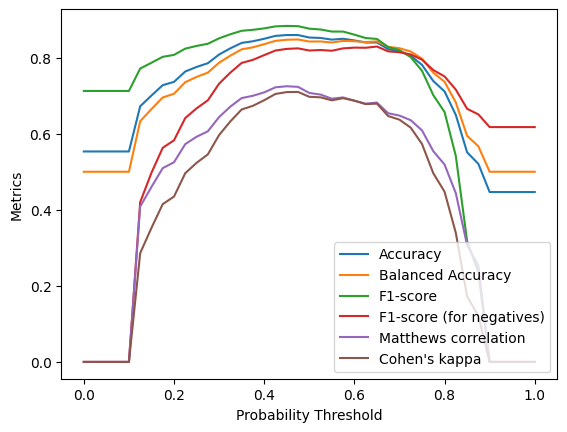

In [49]:
pred_prob_adaboost_heart = AdaBoostClassifier(estimator = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth = 5),learning_rate = 0.01,n_estimators = 250).fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease']).predict_proba(X = heart_final.iloc[:,range(0,17)])

accuracy_scores_adaboost_heart = np.zeros(41)
balanced_accuracy_scores_adaboost_heart = np.zeros(41)
f1_scores_adaboost_heart = np.zeros(41)
f1_scores_neg_adaboost_heart = np.zeros(41)
matthews_corrcoefs_adaboost_heart = np.zeros(41)
cohen_kappa_scores_adaboost_heart = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_adaboost_heart[k] = accuracy_score(obs_heart,(pred_prob_adaboost_heart[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_adaboost_heart[k] = balanced_accuracy_score(obs_heart,(pred_prob_adaboost_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_adaboost_heart[k] = f1_score(obs_heart,(pred_prob_adaboost_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_adaboost_heart[k] = f1_score(obs_heart,(pred_prob_adaboost_heart[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_adaboost_heart[k] = matthews_corrcoef(obs_heart,(pred_prob_adaboost_heart[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_adaboost_heart[k] = cohen_kappa_score(obs_heart,(pred_prob_adaboost_heart[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_adaboost_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_adaboost_heart)
plt.plot(accuracy_thresholds,f1_scores_adaboost_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_adaboost_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_adaboost_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_adaboost_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [50]:
roc_auc_score(obs_heart,pred_prob_adaboost_heart[:,1])

0.932098617246015

In [51]:
brier_score_loss(obs_heart,pred_prob_adaboost_heart[:,1])

0.11308262047599772

In [52]:
log_loss(obs_heart,pred_prob_adaboost_heart[:,1])

0.3799142983328346

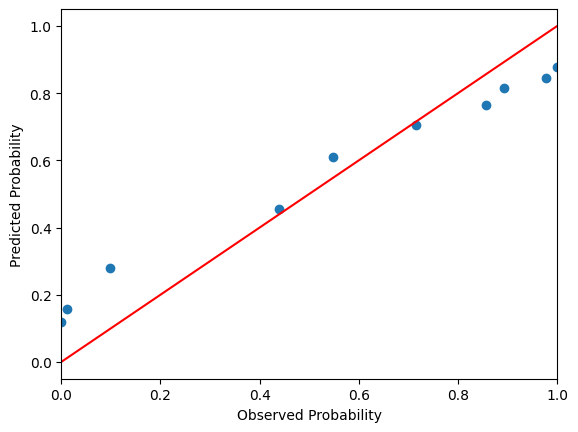

In [53]:
prob_true_adaboost_heart, prob_pred_adaboost_heart = calibration_curve(obs_heart,pred_prob_adaboost_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_adaboost_heart,prob_pred_adaboost_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

Let us cross-validate the performance metrics for the AdaBoost model.

In [54]:
# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_adaboost =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]


        adaboost_heart_new = AdaBoostClassifier(estimator = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth = 5),learning_rate = 0.01,n_estimators = 250)
        adaboost_heart_fit_new = adaboost_heart_new.fit(X = heart_train.iloc[:,range(0,17)], y = heart_train['heart_disease'])
        pred_adaboost_heart_heart_new = adaboost_heart_fit_new.predict(X = heart_test.iloc[:,range(0,17)])
        pred_prob_adaboost_heart_heart_new = adaboost_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,17)])
        logitp_adaboost_new = np.log(np.clip(pred_prob_adaboost_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_adaboost_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_adaboost.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_adaboost_heart_heart_new)
        metrics_cv_heart_adaboost.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_adaboost_heart_heart_new)
        metrics_cv_heart_adaboost.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_adaboost_heart_heart_new[:,1])
        metrics_cv_heart_adaboost.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_adaboost_heart_heart_new[:,1])
        metrics_cv_heart_adaboost.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_adaboost_heart_heart_new[:,1])
        metrics_cv_heart_adaboost.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_adaboost_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1
        
metrics_cv_heart_adaboost.mean()

Balanced Accuracy       0.753163
Matthews Correlation    0.520899
AUC                     0.829444
Brier score             0.164791
Log loss                0.502919
Calibration             1.195433
dtype: object

We observe that the AdaBoost model is pretty similar to the random forest model in terms of performance.

### GBM Algorithm <a class="anchor" id="gradient_boosting-heart"></a>

We mentioned in the previous subsection that the Adaboost algorithm optimizes by Newton-like steps the expected exponential criterion $\mathbb{E}_{Y\mid x}\text{ exp}(- YF(x))$; the minimization of the exponential criterion corresponds to modeling half-log odds $F(x) = \frac{1}{2}\text{log}\frac{P(Y = 1 \mid x)}{P(Y = -1 \mid x)}$. This is (up to a multiplication constant) equivalent to logistic regression  $F(x) = \text{log}\frac{P(Y = 1 \mid x)}{P(Y = -1 \mid x)}$. Logistic regression corresponds to maximization of the binomial log-likelihood (aka deviance, aka log-loss) $L(y, F(x)) = \text{log }(1+e^{-2yF(x)}).$ Hence, minimizing the exponential criterion and maximizing the binomial deviance yield the same solution for population distributions.

However, these two optimization criteria differ for a finite amount of data. It can be shown that the exponential criterion places much more weight on observations with large negative margins $yF(x)$ (more than binomial deviance, hinge-loss, and accuracy); see [Figure 10.4, [5](#5)]. Consequently, AdaBoost's performance is much less robust in noisy settings, in which missclassifications are more common [[5](#5)].

Hence, it may be beneficial to consider analogues to the Adaboost-like tree algorithm for other loss functions $L(y, F(x))$ such as deviance. This general meta-algorithm is known as a gradient boosting machine (GBM)  [[5](#5),[10](#10)] 

1. Initialize a constant model $F_0(x) = \text{arg min}_\gamma \sum_{i = 1}^N L(y, \gamma)$
2. For $m = 1$ to $M$ do
    1. Compute *pseudo-residuals* $r_{i,m} = - \frac{\partial L(y_i,F(x_i))}{\partial F(x_i)} \mid_{F(x) = F_{m-1}(x)}$ for $i = 1, \ldots, N$
    2. Fit a base learner $h_m(x)$ (e.g., shalow decision trees) on training set $\{(y_i,r_{i,m})\}_{i = 1, \ldots, N}$
    3. Compute $\gamma_m$ as $$\gamma_m =  \text{arg min}_{\gamma_m} \sum_{i = 1}^N L(y_i, F_{m-1}(x) + \gamma_m h_m(x) )$$
    4. $F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$

Looking at the algorithm, it is reminiscent of *gradient descent* with a line search, in which the optimization variables are the values of $F$ at the data points $x_i$.

We can fit GBM with classification trees via *GradientBoostingClassifier*. Again,  we will optimize for the hyperparameters *n_estimators*, *learning_rate*, and *max_depth* with respect to log loss. 

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
np.random.seed(123)
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)

parameters = {'n_estimators':[100, 250, 500, 1000],'learning_rate':[0.01, 0.05, 0.1, 0.5],'max_depth':[1, 2, 5, 10]}
gbm_gridcv_heart = GridSearchCV(estimator=GradientBoostingClassifier(),param_grid=parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
gbm_gridcv_heart_fit = gbm_gridcv_heart.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
gbm_gridcv_heart_fit.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

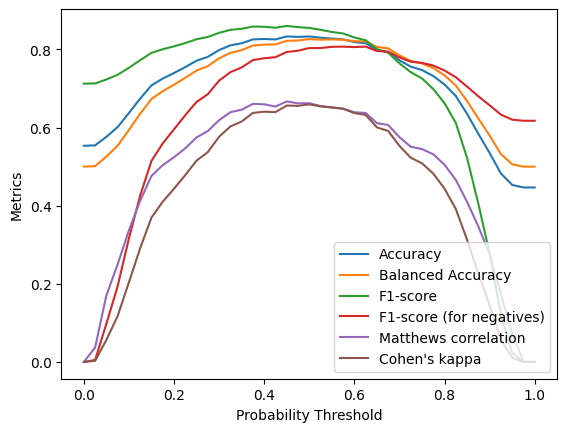

In [56]:
pred_prob_gbm_heart = GradientBoostingClassifier(max_depth = 2, learning_rate = 0.1, n_estimators = 100).fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease']).predict_proba(X = heart_final.iloc[:,range(0,17)])

accuracy_scores_gbm_heart = np.zeros(41)
balanced_accuracy_scores_gbm_heart = np.zeros(41)
f1_scores_gbm_heart = np.zeros(41)
f1_scores_neg_gbm_heart = np.zeros(41)
matthews_corrcoefs_gbm_heart = np.zeros(41)
cohen_kappa_scores_gbm_heart = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_gbm_heart[k] = accuracy_score(obs_heart,(pred_prob_gbm_heart[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_gbm_heart[k] = balanced_accuracy_score(obs_heart,(pred_prob_gbm_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_gbm_heart[k] = f1_score(obs_heart,(pred_prob_gbm_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_gbm_heart[k] = f1_score(obs_heart,(pred_prob_gbm_heart[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_gbm_heart[k] = matthews_corrcoef(obs_heart,(pred_prob_gbm_heart[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_gbm_heart[k] = cohen_kappa_score(obs_heart,(pred_prob_gbm_heart[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_gbm_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_gbm_heart)
plt.plot(accuracy_thresholds,f1_scores_gbm_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_gbm_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_gbm_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_gbm_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [57]:
roc_auc_score(obs_heart,pred_prob_gbm_heart[:,1])

0.909031111964663

In [58]:
brier_score_loss(obs_heart,pred_prob_gbm_heart[:,1])

0.12287892120181679

In [59]:
log_loss(obs_heart,pred_prob_gbm_heart[:,1])

0.3958237117656203

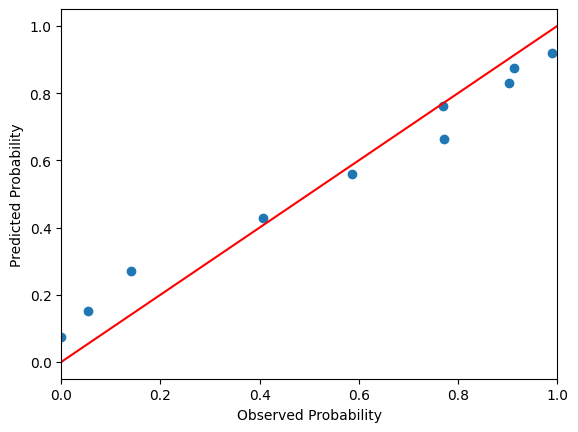

In [60]:
prob_true_gbm_heart, prob_pred_gbm_heart = calibration_curve(obs_heart,pred_prob_gbm_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_gbm_heart,prob_pred_gbm_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

In [61]:
# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_gbm =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]


        gbm_heart_new = GradientBoostingClassifier(max_depth = 2, learning_rate = 0.1, n_estimators = 100)
        gbm_heart_fit_new = gbm_heart_new.fit(X = heart_train.iloc[:,range(0,17)], y = heart_train['heart_disease'])
        pred_gbm_heart_heart_new = gbm_heart_fit_new.predict(X = heart_test.iloc[:,range(0,17)])
        pred_prob_gbm_heart_heart_new = gbm_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,17)])
        logitp_gbm_new = np.log(np.clip(pred_prob_gbm_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_gbm_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_gbm.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_gbm_heart_heart_new)
        metrics_cv_heart_gbm.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_gbm_heart_heart_new)
        metrics_cv_heart_gbm.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_gbm_heart_heart_new[:,1])
        metrics_cv_heart_gbm.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_gbm_heart_heart_new[:,1])
        metrics_cv_heart_gbm.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_gbm_heart_heart_new[:,1])
        metrics_cv_heart_gbm.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_gbm_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1
        
metrics_cv_heart_gbm.mean()

Balanced Accuracy        0.77064
Matthews Correlation    0.548211
AUC                     0.841804
Brier score             0.157225
Log loss                0.484744
Calibration             1.105964
dtype: object

We observe that the results for GBM with the log loss function are slightly better than those with the exponential loss (AdaBoost). 

One important modification of the GBM algorithm that will be crucial in the next part, in which we explore neural networks, is the use of observation subsampling in the construction of individual boosting trees [[11](#11)]. In other words, we use only an estimate of the gradient of the loss function, based on a fraction of the training data rather than the entire dataset. This method is known as *stochastic gradient descent*, and it is especially crucial when dealing with large datasets for which evaluating gradients would be too computationally expensive.

In [62]:
np.random.seed(123)
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)

parameters = {'n_estimators':[100, 250, 500],'learning_rate':[0.01, 0.05, 0.1, 0.5],'max_depth':[1, 2, 5],'subsample':[0.1, 0.25, 0.5, 1]}
gbm_gridcv_heart2 = GridSearchCV(estimator=GradientBoostingClassifier(),param_grid=parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
gbm_gridcv_heart_fit2 = gbm_gridcv_heart2.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
gbm_gridcv_heart_fit2.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1}

For our model, subsampling does not seem to improve performance.

### XGBoost <a class="anchor" id="xgboost-heart"></a>

XGBoost is a mature, highly efficient implementation of GBMs introduced in [[12](#12)] and has been continuously developed since then. XGBoost introduced an approximate algorithm for split finding (replacing an expensive exhaustive search) and support for sparse data. XGBoost considers a regularized loss function at each iteration $m$ $$ L_m(y,F(x)) = \sum_{i = 1}^n L(y_i, \hat{y}_{i,m-1} + \gamma_m h_m(x)) + \Omega(h_m),$$ where $\Omega(h_m)$ is a regularization term; $\Omega(h) = \gamma T + \alpha |w| + \lambda \Vert w^2\Vert$ for a classificition tree $h(x) = \sum_{j = 1}^T w_j I(x \in R_j).$ Since optimizing the whole $h_m$  classification tree wrt $L_m(y, F(x))$ is computationally intractable, XGboost uses a greedy heuristic: it iteratively adds branches to the tree, and it finds the optimal weights $w$ for each considered split. The node is added to the tree provided that the best found split decreases the loss $L_m(y, F(x))$ (notice that each node costs at least $\gamma $).

XGBoost contains a bunch of hyperparameters, such as

1. General hyperparameters: *n_estimators*, *learning_rate*
2. Tree hyperparameters: *max_depth*, *min_child_weight* (roughly speaking, the minimum number of instances in each node)
3. Regularization hyperparameters: *min_split_loss* ($\gamma$), *reg_alpha* ($\alpha$), and *reg_lambda* ($\lambda$)
4. Stochastic hyperparameters: *subsample* (ratio of rows sampled when building a tree) and *colsample_bytree*, *colsample_bylevel*, and *colsample_bynode* (ratio of columns sampled for each tree, level of a tree, and node, respectively)


Consequently, an exhaustive grid-based search for tuning would be too cumbersome. Instead, we will use a heuristic from [[13](#13)] to tune the hyperparameters. 

1. Crank up the number of trees and tune the learning rate with early stopping (if the loss does not improve in *early_stopping_rounds* iterations on the validation dataset, the learning is interrupted)

In [63]:
from xgboost import XGBClassifier

np.random.seed(123)

n_repeats = 5
folds = 10

learning_rate_grid_search_xgb =  pd.DataFrame(index=range(6),columns = ['learning_rate','score','iter'])
learning_rate_grid_search_xgb.iloc[:,0] = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
learning_rate_grid_search_xgb.iloc[:,1] = np.zeros(6)
learning_rate_grid_search_xgb.iloc[:,2] = np.zeros(6)

for repeats in range(n_repeats):
    
    k = 0
    kf = KFold(n_splits = folds) # create folds
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)

    for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
        
        scores = 0
        iteration = 0

        for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
            
            train_set = idx_cv[train_index]
            test_set = idx_cv[test_index]
            
            heart_train = heart_final.iloc[train_set]
            heart_test = heart_final.iloc[test_set]
            
            xgb_heart_new = XGBClassifier(early_stopping_rounds = 50, objective = 'binary:logistic', n_estimators = 5000, learning_rate = learning_rate, eval_metric='logloss')
            xgb_heart_new_fit = xgb_heart_new.fit(heart_train.iloc[:,range(0,17)], heart_train['heart_disease'], eval_set=[(heart_test.iloc[:,range(0,17)], heart_test['heart_disease'])], verbose = False)

            scores = scores + xgb_heart_new_fit.best_score
            iteration = iteration + xgb_heart_new_fit.best_iteration
            
        
        learning_rate_grid_search_xgb.iloc[k,1] = learning_rate_grid_search_xgb.iloc[k,1] + scores
        learning_rate_grid_search_xgb.iloc[k,2] = learning_rate_grid_search_xgb.iloc[k,2] + iteration
        
        k = k + 1

learning_rate_grid_search_xgb.iloc[:,1] = learning_rate_grid_search_xgb.iloc[:,1]/(n_repeats*folds)
learning_rate_grid_search_xgb.iloc[:,2] = learning_rate_grid_search_xgb.iloc[:,2]/(n_repeats*folds)  

In [64]:
learning_rate_grid_search_xgb

,learning_rate,score,iter
0,0.001,0.499627,2433.96
1,0.005,0.497079,564.6
2,0.01,0.49695,307.88
3,0.05,0.495475,66.38
4,0.1,0.494599,33.88
5,0.5,0.505363,5.24


In [65]:
learning_rate_grid_search_xgb.loc[learning_rate_grid_search_xgb['score'].idxmin()]

learning_rate         0.1
score            0.494599
iter                33.88
Name: 4, dtype: object

2. Tune tree-specific hyperparameters

In [66]:
np.random.seed(123) 

cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'max_depth':[1, 2, 3, 6, 10, 20, 40],'min_child_weight':[1, 2, 3, 6, 10, 20, 40]} # default max_depth = 6, min_child_weight = 1
xgb_gridcv_heart1 = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', n_estimators = 50, learning_rate = 0.1),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
xgb_gridcv_heart_fit1 = xgb_gridcv_heart1.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
xgb_gridcv_heart_fit1.best_params_

{'max_depth': 3, 'min_child_weight': 1}

3. Explore stochastic GBM attributes

In [67]:
np.random.seed(123)

cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'subsample':[0.1, 0.25, 0.5, 0.75, 1],'colsample_bynode':[0.1, 0.25, 0.5, 0.75, 1]} #default subsample = 1, colsample_bynode = 1
xgb_gridcv_heart2 = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', n_estimators = 50, learning_rate = 0.1, max_depth = 3, min_child_weight = 1),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
xgb_gridcv_heart_fit2 = xgb_gridcv_heart2.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
xgb_gridcv_heart_fit2.best_params_

{'colsample_bynode': 0.5, 'subsample': 1}

4. If substantial overfitting occurs (e.g., large differences between train and CV error) explore regularization hyperparameters

In [68]:
# cross-validation
np.random.seed(123)

rep = 5
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_xgb =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])
metrics_cv_heart_xgb_pred =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]

        xgb_heart_new = XGBClassifier(objective = 'binary:logistic', n_estimators = 50, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, colsample_bynode =  0.5, subsample = 1)
        xgb_heart_fit_new = xgb_heart_new.fit(X = heart_train.iloc[:,range(0,17)], y = heart_train['heart_disease'])
        
        
        pred_xgb_heart_heart_new = xgb_heart_fit_new.predict(X = heart_train.iloc[:,range(0,17)])
        pred_prob_xgb_heart_heart_new = xgb_heart_fit_new.predict_proba(X = heart_train.iloc[:,range(0,17)])
        logitp_xgb_new = np.log(np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_xgb_pred.iloc[k,0] = balanced_accuracy_score(heart_train['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb_pred.iloc[k,1] = matthews_corrcoef(heart_train['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb_pred.iloc[k,2] = roc_auc_score(heart_train['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_pred.iloc[k,3] = brier_score_loss(heart_train['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_pred.iloc[k,4] = log_loss(heart_train['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_pred.iloc[k,5] = sm.Logit(endog= heart_train['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_xgb_new).assign(const=1)).fit(disp=0).params.iloc[0]
        
        
        pred_xgb_heart_heart_new = xgb_heart_fit_new.predict(X = heart_test.iloc[:,range(0,17)])
        pred_prob_xgb_heart_heart_new = xgb_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,17)])
        logitp_xgb_new = np.log(np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_xgb.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_xgb_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1

In [69]:
# train set
metrics_cv_heart_xgb_pred.mean()

Balanced Accuracy       0.826198
Matthews Correlation    0.664707
AUC                     0.908863
Brier score             0.123341
Log loss                0.397084
Calibration              1.57496
dtype: object

In [70]:
# test set
metrics_cv_heart_xgb.mean()

Balanced Accuracy       0.770989
Matthews Correlation    0.550484
AUC                     0.842029
Brier score             0.156659
Log loss                0.481753
Calibration             1.143244
dtype: object

The performance metrics did not decrease that dramatically. We do not expect much additional regularization to be needed. 

In [71]:
np.random.seed(123)
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'reg_alpha':[0, 0.01, 0.1, 1, 10],'reg_lambda':[0, 0.01, 0.1, 1, 10], 'min_split_loss':[0, 0.01, 0.1, 1, 10]} # default reg_alpha = 0, reg_lambda = 1, min_split_loss = 0

xgb_gridcv_heart3 = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', n_estimators = 50, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, colsample_bynode =  0.5, subsample = 1.0),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
xgb_gridcv_heart_fit3 = xgb_gridcv_heart3.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
xgb_gridcv_heart_fit3.best_params_

{'min_split_loss': 0, 'reg_alpha': 0.01, 'reg_lambda': 1}

Indeed, the optimal regularization found by the cross-validation is almost identical to the one we used. 

5. If you find hyperparameter values that are substantially different from the default settings, be sure to retune the learning rate.

In [72]:
np.random.seed(123) 
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5],'n_estimators':[50, 100, 200, 300, 500, 1000]}

xgb_gridcv_heart4 = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', max_depth = 3, min_child_weight = 1, colsample_bynode =  0.5, subsample = 1.0, reg_alpha = 0.01, reg_lambda = 1, min_split_loss = 0), param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
xgb_gridcv_heart_fit4 = xgb_gridcv_heart4.fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease'])
xgb_gridcv_heart_fit4.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

The optimal learning rate remained unchanged. Hence, let us evaluate the performance of the resulting model.

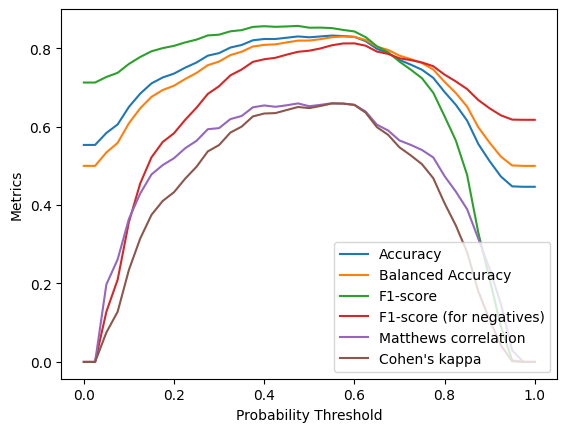

In [73]:
pred_prob_xgb_heart = XGBClassifier(objective = 'binary:logistic', n_estimators = 50, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, colsample_bynode =  0.5, subsample = 1.0, reg_alpha = 0.01, reg_lambda = 1, min_split_loss = 0).fit(X = heart_final.iloc[:,range(0,17)], y = heart_final['heart_disease']).predict_proba(X = heart_final.iloc[:,range(0,17)])

accuracy_scores_xgb_heart = np.zeros(41)
balanced_accuracy_scores_xgb_heart = np.zeros(41)
f1_scores_xgb_heart = np.zeros(41)
f1_scores_neg_xgb_heart = np.zeros(41)
matthews_corrcoefs_xgb_heart = np.zeros(41)
cohen_kappa_scores_xgb_heart = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_xgb_heart[k] = accuracy_score(obs_heart,(pred_prob_xgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_xgb_heart[k] = balanced_accuracy_score(obs_heart,(pred_prob_xgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_xgb_heart[k] = f1_score(obs_heart,(pred_prob_xgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_xgb_heart[k] = f1_score(obs_heart,(pred_prob_xgb_heart[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_xgb_heart[k] = matthews_corrcoef(obs_heart,(pred_prob_xgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_xgb_heart[k] = cohen_kappa_score(obs_heart,(pred_prob_xgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_xgb_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_xgb_heart)
plt.plot(accuracy_thresholds,f1_scores_xgb_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_xgb_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_xgb_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_xgb_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [74]:
roc_auc_score(obs_heart,pred_prob_xgb_heart[:,1])

0.9058887075091222

In [75]:
brier_score_loss(obs_heart,pred_prob_xgb_heart[:,1])

0.12484809310167903

In [76]:
log_loss(obs_heart,pred_prob_xgb_heart[:,1])

0.40095825158217613

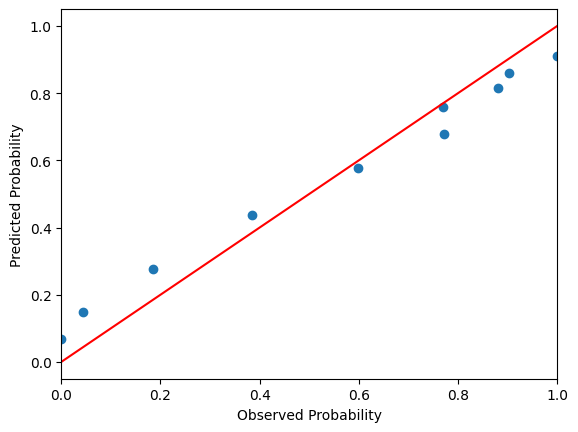

In [77]:
prob_true_xgb_heart, prob_pred_xgb_heart = calibration_curve(obs_heart,pred_prob_xgb_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_xgb_heart,prob_pred_xgb_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

In [78]:
# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_xgb_final =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]

        xgb_heart_new = XGBClassifier(objective = 'binary:logistic', n_estimators = 50, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, colsample_bynode =  0.5, subsample = 1.0, reg_alpha = 0.01, reg_lambda = 1, min_split_loss = 0)
        xgb_heart_fit_new = xgb_heart_new.fit(X = heart_train.iloc[:,range(0,17)], y = heart_train['heart_disease'])
                
        pred_xgb_heart_heart_new = xgb_heart_fit_new.predict(X = heart_test.iloc[:,range(0,17)])
        pred_prob_xgb_heart_heart_new = xgb_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,17)])
        logitp_xgb_new = np.log(np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_xgb_final.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb_final.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb_final.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_xgb_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1
        
metrics_cv_heart_xgb_final.mean()

Balanced Accuracy       0.769737
Matthews Correlation    0.548244
AUC                     0.841061
Brier score              0.15779
Log loss                 0.48452
Calibration             1.139607
dtype: object

The performance is almost identical to the GBM model from the previou section. 

#### Categorical Features <a class="anchor" id="categorical-heart"></a>

One aspect we have mostly ignored to this point is dealing with the categorical features. We almost automatically used dummy coding, which is an adequate method for handling categorical features, provided the number of categories is not too high. Still, when considering, for example, the feature **cp** (chest pain type: typical angina, atypical angina, non-anginal, asymptomatic), since we preprocessed the categorical data by dummy coding, the algorithm for constructing decision trees can only consider splits of the form "typical angina vs. not typical angina" or "asymptomatic vs not asymptomatic" and not the splits such as "typical angina or atypical angina vs. non-anginal or asymptomatic". In other words, we replaced a potentially strong predictor, **cp**, with a bunch of weaker predictors.

Consequently, XGBoost and other mature GBM implementations use more advanced algorithms to handle categorical features, which allows these more advanced splits. Namely, XGBoost uses an approach based on theoretical results on optimal splitting for categorical features [[14](#14)], initially used in LightGBM (which we will discuss in a bit) [[15](#15)].

First, we need to encode the categorical features using integers (we already did this to prepare the dataset for MissForrest imputation, thus, we will use the dataset we obtained from MissForrest) and declare that they represent categorical features (which is required for *XGBClassifier*).

In [79]:
heart_cat = heart_imp_MissForest.copy()
heart_cat['heart_disease'] = (heart['num'] > 0).astype(int)
heart_cat[['sex','dataset','cp','fbs','restecg','exang','slope','thal']] =  heart_cat[['sex','dataset','cp','fbs','restecg','exang','slope','thal']].astype(int).astype("category")

Then, we will run the XGBoost classifier with the parameter *enable_categorical = True*.

In [80]:
# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_xgb_final =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_cat.iloc[train_set]
        heart_test = heart_cat.iloc[test_set]

        xgb_heart_new = XGBClassifier(objective = 'binary:logistic', enable_categorical=True, n_estimators = 50, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, colsample_bynode =  0.5, subsample = 1.0, reg_alpha = 0.01, reg_lambda = 1, min_split_loss = 0)
        xgb_heart_fit_new = xgb_heart_new.fit(X = heart_train.iloc[:,range(0,13)], y = heart_train['heart_disease'])
                
        pred_xgb_heart_heart_new = xgb_heart_fit_new.predict(X = heart_test.iloc[:,range(0,13)])
        pred_prob_xgb_heart_heart_new = xgb_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,13)])
        logitp_xgb_new = np.log(np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_xgb_final.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb_final.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb_final.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_xgb_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1
        
metrics_cv_heart_xgb_final.mean()

Balanced Accuracy       0.805455
Matthews Correlation    0.618021
AUC                     0.875917
Brier score             0.137765
Log loss                0.434123
Calibration              1.15498
dtype: object

The performance of our model improved significantly. This is actually our best model by far (up to this point, our best was a simple logistic regression). Let us repeat the parameter tuning to see if we can improve performance a bit. 

In [81]:
np.random.seed(123)

n_repeats = 5
folds = 10

learning_rate_grid_search_xgb =  pd.DataFrame(index=range(6),columns = ['learning_rate','score','iter'])
learning_rate_grid_search_xgb.iloc[:,0] = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
learning_rate_grid_search_xgb.iloc[:,1] = np.zeros(6)
learning_rate_grid_search_xgb.iloc[:,2] = np.zeros(6)

for repeats in range(n_repeats):
    
    k = 0
    kf = KFold(n_splits = folds) # create folds
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)

    for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
        
        scores = 0
        iteration = 0

        for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
            
            train_set = idx_cv[train_index]
            test_set = idx_cv[test_index]
            
            heart_train = heart_cat.iloc[train_set]
            heart_test = heart_cat.iloc[test_set]
            
            xgb_heart_new = XGBClassifier(early_stopping_rounds = 50, objective = 'binary:logistic', enable_categorical = True, n_estimators = 5000, learning_rate = learning_rate, eval_metric = 'logloss')
            xgb_heart_new_fit = xgb_heart_new.fit(heart_train.iloc[:,range(0,13)], heart_train['heart_disease'], eval_set=[(heart_test.iloc[:,range(0,13)], heart_test['heart_disease'])], verbose = False)

            scores = scores + xgb_heart_new_fit.best_score
            iteration = iteration + xgb_heart_new_fit.best_iteration
            
        
        learning_rate_grid_search_xgb.iloc[k,1] = learning_rate_grid_search_xgb.iloc[k,1] + scores
        learning_rate_grid_search_xgb.iloc[k,2] = learning_rate_grid_search_xgb.iloc[k,2] + iteration
        
        k = k + 1

learning_rate_grid_search_xgb.iloc[:,1] = learning_rate_grid_search_xgb.iloc[:,1]/(n_repeats*folds)
learning_rate_grid_search_xgb.iloc[:,2] = learning_rate_grid_search_xgb.iloc[:,2]/(n_repeats*folds)  

In [82]:
learning_rate_grid_search_xgb.loc[learning_rate_grid_search_xgb['score'].idxmin()]

learning_rate         0.1
score            0.449329
iter                36.44
Name: 4, dtype: object

In [83]:
np.random.seed(123) 
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'max_depth':[1, 2, 3, 6, 10, 20, 40],'min_child_weight':[1, 2, 3, 6, 10, 20, 40]}

xgb_gridcv_heart1 = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', enable_categorical=True, n_estimators = 50, learning_rate = 0.1),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
xgb_gridcv_heart_fit1 = xgb_gridcv_heart1.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'])
xgb_gridcv_heart_fit1.best_params_

{'max_depth': 2, 'min_child_weight': 3}

In [84]:
np.random.seed(123)
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'subsample':[0.1, 0.25, 0.5, 0.75, 1],'colsample_bynode':[0.1, 0.25, 0.5, 0.75, 1]} 

xgb_gridcv_heart2 = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', enable_categorical=True, n_estimators = 50, learning_rate = 0.1, max_depth = 2, min_child_weight = 3),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
xgb_gridcv_heart_fit2 = xgb_gridcv_heart2.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'])
xgb_gridcv_heart_fit2.best_params_

{'colsample_bynode': 1, 'subsample': 1}

In [85]:
np.random.seed(123)
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'reg_alpha':[0, 0.01, 0.1, 1, 10],'reg_lambda':[0, 0.01, 0.1, 1, 10], 'min_split_loss':[0, 0.01, 0.1, 1, 10]} 

xgb_gridcv_heart3 = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', enable_categorical=True, n_estimators = 50, learning_rate = 0.1, max_depth = 2, min_child_weight = 3, colsample_bynode =  1.0, subsample = 1.0),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
xgb_gridcv_heart_fit3 = xgb_gridcv_heart3.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'])
xgb_gridcv_heart_fit3.best_params_

{'min_split_loss': 1, 'reg_alpha': 0, 'reg_lambda': 1}

In [86]:
np.random.seed(123) 
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5],'n_estimators':[50, 100, 200, 300, 500, 1000]}

xgb_gridcv_heart4 = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', enable_categorical=True, max_depth = 2, min_child_weight = 3, colsample_bynode =  1.0, subsample = 1.0, reg_alpha = 0, reg_lambda = 1, min_split_loss = 1), param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
xgb_gridcv_heart_fit4 = xgb_gridcv_heart4.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'])
xgb_gridcv_heart_fit4.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

We observe that the estimated optimal parameter changed slightly. Let us perform the final cross-validation. We will also record the CPU time for future reference.

In [87]:
import time
start = time.time()

# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_xgb_final2 =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_cat.iloc[train_set]
        heart_test = heart_cat.iloc[test_set]

        xgb_heart_new = XGBClassifier(objective = 'binary:logistic', enable_categorical=True, n_estimators = 100, learning_rate = 0.1, max_depth = 2, min_child_weight = 3, colsample_bynode =  1.0, subsample = 1.0, reg_alpha = 0, reg_lambda = 1, min_split_loss = 1)
        xgb_heart_fit_new = xgb_heart_new.fit(X = heart_train.iloc[:,range(0,13)], y = heart_train['heart_disease'])
                
        pred_xgb_heart_heart_new = xgb_heart_fit_new.predict(X = heart_test.iloc[:,range(0,13)])
        pred_prob_xgb_heart_heart_new = xgb_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,13)])
        logitp_xgb_new = np.log(np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_xgb_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_xgb_final2.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb_final2.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_xgb_heart_heart_new)
        metrics_cv_heart_xgb_final2.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final2.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final2.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_xgb_heart_heart_new[:,1])
        metrics_cv_heart_xgb_final2.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_xgb_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1
        
end = time.time()
print(end - start)

25.177201747894287


In [88]:
metrics_cv_heart_xgb_final2.mean()

Balanced Accuracy       0.803269
Matthews Correlation    0.613128
AUC                     0.875794
Brier score             0.137718
Log loss                0.433682
Calibration              1.10751
dtype: object

In [89]:
metrics_cv_heart_xgb_final2.std()

Balanced Accuracy       0.040641
Matthews Correlation    0.079829
AUC                     0.035599
Brier score             0.021019
Log loss                0.053778
Calibration             0.242904
dtype: object

We observe that the performance is almost identical compared to the previous XGBoost model.

### LightGBM <a class="anchor" id="lightgbm-heart"></a>

LightGBM [[15](#15)], [[16](#16)] is another GBM, very similar to XGBoost. Its main innovation over XGBoost was histogram-based splitting, which significantly speeds up the construction of classification trees and is now also adopted by XGBoost. Other than that, LightGBM constructs the trees a bit differently. XGBoost constructs trees wide first and then deep, whereas LightGBM constructs trees deep first. In addition, LightGBM runs significantly faster overall than XGBoost. 

Let us train a LightGBM model using the same heuristic as for the XGBoost model. We will use *num_leaves* (number of leaves) instead of *max_depth*, as it better aligns with LightGBM's tree construction strategy.

In [90]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

np.random.seed(123)

n_repeats = 5
folds = 10

learning_rate_grid_search_lgb =  pd.DataFrame(index=range(6),columns = ['learning_rate','score','iter'])
learning_rate_grid_search_lgb.iloc[:,0] = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
learning_rate_grid_search_lgb.iloc[:,1] = np.zeros(6)
learning_rate_grid_search_lgb.iloc[:,2] = np.zeros(6)

for repeats in range(n_repeats):
    
    k = 0
    kf = KFold(n_splits = folds) # create folds
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)

    for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
        
        scores = 0
        iteration = 0

        for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
            
            train_set = idx_cv[train_index]
            test_set = idx_cv[test_index]
            
            heart_train = heart_cat.iloc[train_set]
            heart_test = heart_cat.iloc[test_set]

            lgb_heart_new = LGBMClassifier(objective = 'binary', n_estimators = 5000, learning_rate = learning_rate, eval_metric='logloss')
            lgb_heart_new_fit = lgb_heart_new.fit(heart_train.iloc[:,range(0,13)], heart_train['heart_disease'], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose =False)],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], eval_set=[(heart_test.iloc[:,range(0,13)], heart_test['heart_disease'])])

            scores = scores + lgb_heart_new_fit.best_score_['valid_0']['binary_logloss']
            iteration = iteration + lgb_heart_new_fit.best_iteration_
            
        
        learning_rate_grid_search_lgb.iloc[k,1] = learning_rate_grid_search_lgb.iloc[k,1] + scores
        learning_rate_grid_search_lgb.iloc[k,2] = learning_rate_grid_search_lgb.iloc[k,2] + iteration
        
        k = k + 1

learning_rate_grid_search_lgb.iloc[:,1] = learning_rate_grid_search_lgb.iloc[:,1]/(n_repeats*folds)
learning_rate_grid_search_lgb.iloc[:,2] = learning_rate_grid_search_lgb.iloc[:,2]/(n_repeats*folds)  

In [91]:
learning_rate_grid_search_lgb

,learning_rate,score,iter
0,0.001,0.463121,2216.22
1,0.005,0.461124,496.84
2,0.01,0.459765,265.72
3,0.05,0.460103,54.86
4,0.1,0.459419,26.94
5,0.5,0.469155,4.66


In [92]:
learning_rate_grid_search_lgb.loc[learning_rate_grid_search_xgb['score'].idxmin()]

learning_rate         0.1
score            0.459419
iter                26.94
Name: 4, dtype: object

In [93]:
np.random.seed(123) 

cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'num_leaves': [5, 10, 15, 30, 60, 120], 'min_child_samples': [5, 10, 20, 40, 80, 120, 150]} # num_leaves = 31, min_child_samples = 20
lgb_gridcv_heart1 = GridSearchCV(estimator=LGBMClassifier(objective = 'binary', n_estimators = 50, learning_rate = 0.1),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
lgb_gridcv_heart_fit1 = lgb_gridcv_heart1.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'])
lgb_gridcv_heart_fit1.best_params_,

({'min_child_samples': 120, 'num_leaves': 10},)

In [94]:
np.random.seed(123)
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'subsample':[0.1, 0.25, 0.5, 0.75, 1],'colsample_bynode':[0.1, 0.25, 0.5, 0.75, 1]} # subsample = 1, colsample_bynode = 1

lgb_gridcv_heart2 = GridSearchCV(estimator=LGBMClassifier(objective = 'binary', n_estimators = 50, learning_rate = 0.1, num_leaves = 10, min_child_samples = 120),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
lgb_gridcv_heart_fit2 = lgb_gridcv_heart2.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'])
lgb_gridcv_heart_fit2.best_params_

{'colsample_bynode': 1, 'subsample': 0.1}

In [95]:
np.random.seed(123)
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'reg_alpha':[0, 0.01, 0.1, 1, 10],'reg_lambda':[0, 0.01, 0.1, 1, 10], 'min_split_gain':[0, 0.01, 0.1, 1, 10]} # default reg_alpha = 0, reg_lambda = 0, min_split_gain = 0

lgb_gridcv_heart3 = GridSearchCV(estimator=LGBMClassifier(objective = 'binary', n_estimators = 50, learning_rate = 0.1, num_leaves = 10, min_child_samples = 120, colsample_bynode =  1.0, subsample = 0.1),param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
lgb_gridcv_heart_fit3 = lgb_gridcv_heart3.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'])
lgb_gridcv_heart_fit3.best_params_

{'min_split_gain': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}

In [96]:
np.random.seed(123) 
cv = RepeatedKFold(n_splits = 10, n_repeats = 5)
parameters = {'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5],'n_estimators':[50, 100, 200, 300, 500, 1000]}

lgb_gridcv_heart4 = GridSearchCV(estimator=LGBMClassifier(objective = 'binary', num_leaves = 10, min_child_samples = 120, colsample_bynode =  1.0, subsample = 0.1, reg_alpha = 0.01, reg_lambda = 0.01, min_split_gain = 0.01), param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
lgb_gridcv_heart_fit4 = lgb_gridcv_heart4.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'])
lgb_gridcv_heart_fit4.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

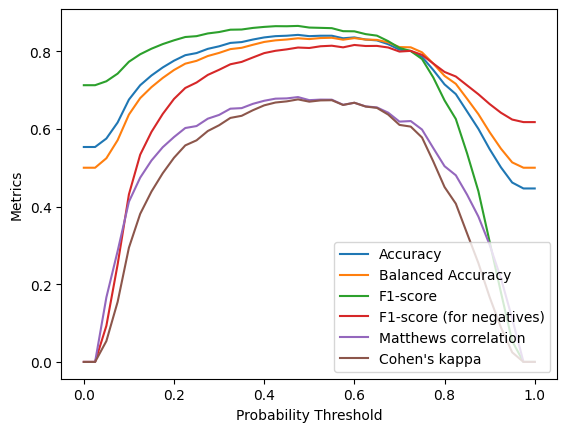

In [97]:
pred_prob_lgb_heart = LGBMClassifier(objective = 'binary', n_estimators = 50, learning_rate = 0.1, num_leaves = 10, min_child_samples = 120, colsample_bynode =  1.0, subsample = 0.1, reg_alpha = 0.01, reg_lambda = 0.01, min_split_gain = 0.01).fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal']).predict_proba(X = heart_cat.iloc[:,range(0,13)])

accuracy_scores_lgb_heart = np.zeros(41)
balanced_accuracy_scores_lgb_heart = np.zeros(41)
f1_scores_lgb_heart = np.zeros(41)
f1_scores_neg_lgb_heart = np.zeros(41)
matthews_corrcoefs_lgb_heart = np.zeros(41)
cohen_kappa_scores_lgb_heart = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_lgb_heart[k] = accuracy_score(obs_heart,(pred_prob_lgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_lgb_heart[k] = balanced_accuracy_score(obs_heart,(pred_prob_lgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_lgb_heart[k] = f1_score(obs_heart,(pred_prob_lgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_lgb_heart[k] = f1_score(obs_heart,(pred_prob_lgb_heart[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_lgb_heart[k] = matthews_corrcoef(obs_heart,(pred_prob_lgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_lgb_heart[k] = cohen_kappa_score(obs_heart,(pred_prob_lgb_heart[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_lgb_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_lgb_heart)
plt.plot(accuracy_thresholds,f1_scores_lgb_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_lgb_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_lgb_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_lgb_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [98]:
roc_auc_score(obs_heart,pred_prob_lgb_heart[:,1])

0.9107763587478395

In [99]:
brier_score_loss(obs_heart,pred_prob_lgb_heart[:,1])

0.11883292738684455

In [100]:
log_loss(obs_heart,pred_prob_lgb_heart[:,1])

0.38444780223283515

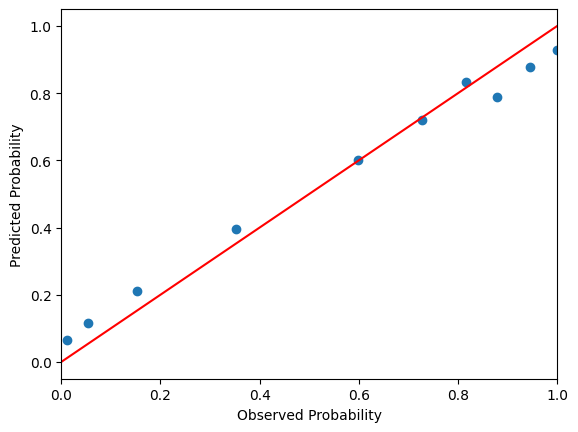

In [101]:
prob_true_lbg_heart, prob_pred_lgb_heart = calibration_curve(obs_heart,pred_prob_lgb_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_lbg_heart,prob_pred_lgb_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

In [102]:
start = time.time()

# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_lgb_final =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_cat.iloc[train_set]
        heart_test = heart_cat.iloc[test_set]

        lgb_heart_new = LGBMClassifier(objective = 'binary', n_estimators = 50, learning_rate = 0.1, num_leaves = 10, min_child_samples = 120, colsample_bynode =  1.0, subsample = 0.1, reg_alpha = 0.01, reg_lambda = 0.01, min_split_gain = 0.01)
        lgb_heart_fit_new = lgb_heart_new.fit(X = heart_train.iloc[:,range(0,13)], y = heart_train['heart_disease'],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'])
                
        pred_lgb_heart_heart_new = lgb_heart_fit_new.predict(X = heart_test.iloc[:,range(0,13)])
        pred_prob_lgb_heart_heart_new = lgb_heart_fit_new.predict_proba(X = heart_test.iloc[:,range(0,13)])
        logitp_lgb_new = np.log(np.clip(pred_prob_lgb_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_lgb_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_lgb_final.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_lgb_heart_heart_new)
        metrics_cv_heart_lgb_final.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_lgb_heart_heart_new)
        metrics_cv_heart_lgb_final.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_lgb_heart_heart_new[:,1])
        metrics_cv_heart_lgb_final.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_lgb_heart_heart_new[:,1])
        metrics_cv_heart_lgb_final.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_lgb_heart_heart_new[:,1])
        metrics_cv_heart_lgb_final.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_lgb_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1
        
end = time.time()
print(end - start)        

13.70726466178894


In [103]:
metrics_cv_heart_lgb_final.mean()

Balanced Accuracy       0.808278
Matthews Correlation    0.625391
AUC                     0.870704
Brier score             0.139452
Log loss                0.440713
Calibration             1.175579
dtype: object

In [104]:
metrics_cv_heart_lgb_final.std()

Balanced Accuracy       0.040363
Matthews Correlation     0.07939
AUC                     0.036448
Brier score             0.020272
Log loss                0.050578
Calibration              0.24914
dtype: object

We observe that the fit of LightGBM is quite similar in performance but noticeably faster than XGBoost.

### CatBoost <a class="anchor" id="catboost-heart"></a>

Catboost [[17](#17)] is the last GBM algorithm we will discuss here. Unlike XGBoost and LightGBM, CatBoost provides an alternative boosting algorithm called *ordered boosting*. One issue with the original boosting algorithm [[10](#10)] is a so-called *prediction shift* [[17](#17)], a systematic bias, caused by the fact that the gradient approximation via the base learner and the loss minimization (i.e., line search) in each step of the GBM algorithm is computed using the same dataset. Ordered boosting solves this issue by estimating a set of supporting models, ensuring that the gradient at $x_i$ in iteration $m$ is approximated without using $F_{m-1}(x_i)$.

CatBoost also includes quite a variety of quantization settings for categorical features (https://catboost.ai/docs/en/references/training-parameters/ctr) with many categories (for which the 0-1 dummy encoding is impractical). These are so-called *target statistics*, in which the category is replaced by the expected target value, aka prevalence. 

Lastly, CatBoost builds symmetric (so-called *oblivious*) decision trees, where the same split is applied to all nodes at the same level.

Let us start with a CatBoost model with  *boosting_type = 'Plain'*, i.e., an GBM algorithm similar to XGBoost and LightGBM. We will again follow our heuristic. Let us first determine the number of iterations and the learning rate.

In [105]:
from catboost import CatBoostClassifier

np.random.seed(123)

n_repeats = 5
folds = 10

learning_rate_grid_search_cat =  pd.DataFrame(index=range(6),columns = ['learning_rate','score','iter'])
learning_rate_grid_search_cat.iloc[:,0] = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
learning_rate_grid_search_cat.iloc[:,1] = np.zeros(6)
learning_rate_grid_search_cat.iloc[:,2] = np.zeros(6)

for repeats in range(n_repeats):
    
    k = 0
    kf = KFold(n_splits = folds) # create folds
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)

    for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
        
        scores = 0
        iteration = 0

        for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
            
            train_set = idx_cv[train_index]
            test_set = idx_cv[test_index]
            
            heart_train = heart_cat.iloc[train_set]
            heart_test = heart_cat.iloc[test_set]

            cat_heart_new = CatBoostClassifier(iterations = 5000, learning_rate = learning_rate, objective = 'Logloss', eval_metric='Logloss', early_stopping_rounds = 50, one_hot_max_size = 256, boosting_type = 'Plain')
            cat_heart_new_fit = cat_heart_new.fit(heart_train.iloc[:,range(0,13)], heart_train['heart_disease'],cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], eval_set=[(heart_test.iloc[:,range(0,13)], heart_test['heart_disease'])], verbose = False)

            scores = scores + cat_heart_new_fit.best_score_['validation']['Logloss']
            iteration = iteration + cat_heart_new_fit.best_iteration_
            
        
        learning_rate_grid_search_cat.iloc[k,1] = learning_rate_grid_search_cat.iloc[k,1] + scores
        learning_rate_grid_search_cat.iloc[k,2] = learning_rate_grid_search_cat.iloc[k,2] + iteration
        
        k = k + 1

learning_rate_grid_search_cat.iloc[:,1] = learning_rate_grid_search_cat.iloc[:,1]/(n_repeats*folds)
learning_rate_grid_search_cat.iloc[:,2] = learning_rate_grid_search_cat.iloc[:,2]/(n_repeats*folds)

In [106]:
learning_rate_grid_search_cat.loc[learning_rate_grid_search_cat['score'].idxmin()]

learning_rate        0.01
score            0.420726
iter               436.62
Name: 2, dtype: object

Since trees are built symmetric, we control merely the depth. 

In [107]:
np.random.seed(123)  
cv = RepeatedKFold(n_splits = 10, n_repeats = 5) # default max_depth = 6
parameters = {'max_depth':[1, 2, 3, 6, 8]}

cat_gridcv_heart1 = GridSearchCV(estimator=CatBoostClassifier(iterations = 450, learning_rate = 0.01, objective = 'Logloss', one_hot_max_size = 256, boosting_type = 'Plain'), param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
cat_gridcv_heart_fit1 = cat_gridcv_heart1.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'], cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False)
cat_gridcv_heart_fit1.best_params_

{'max_depth': 6}

Stochastic hyperparameters in CatBoost are a bit different. *Bernoulli* corresponds to the usual stochastic gardient boosting, *Bayesian* is based on  *Bayesian bootstrap* [[18](#18)]: it generates random sample weights $w = v^t$, where *t* is *bagging_temperature* un $u \sim -\text{log } U(0,1)$.

In [108]:
np.random.seed(123)
parameters_1 = {
    'bootstrap_type':['Bayesian'],
    'bagging_temperature': [0, 1, 10]
}
parameters_2 = {
    'bootstrap_type':['Bernoulli'],
    'subsample': [0.25, 0.5, 0.75, 1]
}

cat_gridcv_heart2 = GridSearchCV(estimator=CatBoostClassifier(iterations = 450, learning_rate = 0.01, max_depth = 6, objective = 'Logloss', one_hot_max_size = 256, boosting_type = 'Plain'), param_grid = [parameters_1, parameters_2], scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
cat_gridcv_heart_fit2 = cat_gridcv_heart2.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'], cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False)
cat_gridcv_heart_fit2.best_params_

{'bagging_temperature': 0, 'bootstrap_type': 'Bayesian'}

No resampling/bootstrap seems needed, hence, we can set *bootstrap_type = 'No'*.

In [109]:
np.random.seed(123)  
cv = RepeatedKFold(n_splits = 10, n_repeats = 5) # default l2_leaf_reg = 3
parameters = {'l2_leaf_reg':[1, 2, 3, 6]}

cat_gridcv_heart3 = GridSearchCV(estimator=CatBoostClassifier(iterations = 450, learning_rate = 0.01, max_depth = 6, bootstrap_type = 'No', objective = 'Logloss', one_hot_max_size = 256, boosting_type = 'Plain'), param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
cat_gridcv_heart_fit3 = cat_gridcv_heart3.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'], cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False)
cat_gridcv_heart_fit3.best_params_

{'l2_leaf_reg': 2}

In [110]:
np.random.seed(123)  
cv = RepeatedKFold(n_splits = 10, n_repeats = 5) # default l2_leaf_reg = 3
parameters = {'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1],'iterations':[100, 200, 450, 600, 800]}

cat_gridcv_heart4 = GridSearchCV(estimator=CatBoostClassifier(max_depth = 6, bootstrap_type = 'No', l2_leaf_reg = 2, objective = 'Logloss', one_hot_max_size = 256, boosting_type = 'Plain'), param_grid = parameters, scoring = 'neg_log_loss', n_jobs = 5, cv = cv)
cat_gridcv_heart_fit4 = cat_gridcv_heart4.fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'], cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False)
cat_gridcv_heart_fit4.best_params_

{'iterations': 800, 'learning_rate': 0.005}

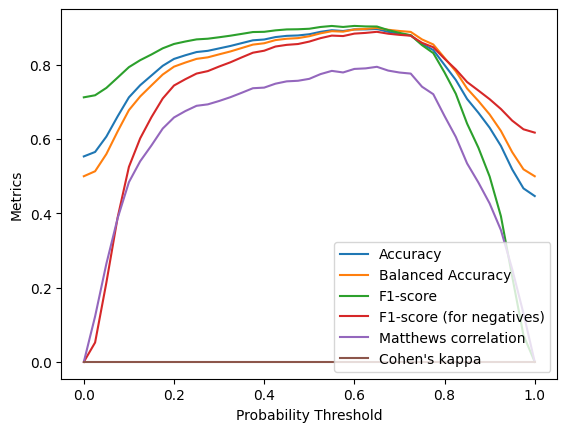

In [111]:
pred_prob_cat_heart = CatBoostClassifier(objective = 'Logloss', iterations = 800, learning_rate = 0.005, max_depth = 6, bootstrap_type = 'No',l2_leaf_reg = 2 , one_hot_max_size = 256, boosting_type = 'Plain').fit(X = heart_cat.iloc[:,range(0,13)], y = heart_cat['heart_disease'],cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False).predict_proba(X = heart_cat.iloc[:,range(0,13)])

accuracy_scores_cat_heart = np.zeros(41)
balanced_accuracy_scores_cat_heart = np.zeros(41)
f1_scores_cat_heart = np.zeros(41)
f1_scores_neg_cat_heart = np.zeros(41)
matthews_corrcoefs_cat_heart = np.zeros(41)
cohen_kappa_scores_cat_heart = np.zeros(41)

for k in range(41):
    accuracy_thresholds[k] = k/40
    accuracy_scores_cat_heart[k] = accuracy_score(obs_heart,(pred_prob_cat_heart[:,1] > accuracy_thresholds[k]).astype(int))
    balanced_accuracy_scores_cat_heart[k] = balanced_accuracy_score(obs_heart,(pred_prob_cat_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_cat_heart[k] = f1_score(obs_heart,(pred_prob_cat_heart[:,1] > accuracy_thresholds[k]).astype(int))
    f1_scores_neg_cat_heart[k] = f1_score(obs_heart,(pred_prob_cat_heart[:,1] > accuracy_thresholds[k]).astype(int),pos_label=0)
    matthews_corrcoefs_cat_heart[k] = matthews_corrcoef(obs_heart,(pred_prob_cat_heart[:,1] > accuracy_thresholds[k]).astype(int))
    cohen_kappa_scores_lgb_heart[k] = cohen_kappa_score(obs_heart,(pred_prob_cat_heart[:,1] > accuracy_thresholds[k]).astype(int))
    
    
plt.plot(accuracy_thresholds,accuracy_scores_cat_heart)
plt.plot(accuracy_thresholds,balanced_accuracy_scores_cat_heart)
plt.plot(accuracy_thresholds,f1_scores_cat_heart)
plt.plot(accuracy_thresholds,f1_scores_neg_cat_heart)
plt.plot(accuracy_thresholds,matthews_corrcoefs_cat_heart)
plt.plot(accuracy_thresholds,cohen_kappa_scores_cat_heart)

plt.legend(['Accuracy','Balanced Accuracy','F1-score','F1-score (for negatives)','Matthews correlation',"Cohen's kappa"], loc="lower right")
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics');

In [112]:
roc_auc_score(obs_heart,pred_prob_cat_heart[:,1])

0.9677789514115613

In [113]:
brier_score_loss(obs_heart,pred_prob_cat_heart[:,1])

0.08297871112093294

In [114]:
log_loss(obs_heart,pred_prob_cat_heart[:,1])

0.28747610655393757

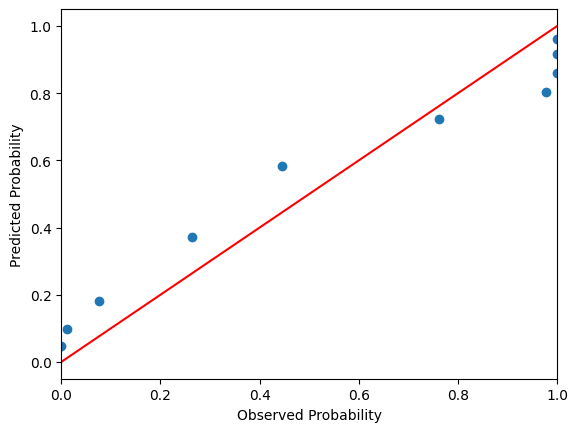

In [115]:
prob_true_cat_heart, prob_pred_cat_heart = calibration_curve(obs_heart,pred_prob_cat_heart[:,1], n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_cat_heart,prob_pred_cat_heart)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

In [116]:
start = time.time()

# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_cat1 =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_cat.iloc[train_set]
        heart_test = heart_cat.iloc[test_set]

        cat_heart_new = CatBoostClassifier(objective = 'Logloss', iterations = 800, learning_rate = 0.005, max_depth = 6, bootstrap_type = 'No',l2_leaf_reg = 2 , one_hot_max_size = 256, boosting_type = 'Plain')
        cat_heart_fit_new = cat_heart_new.fit(X = heart_train.iloc[:,range(0,13)], y = heart_train['heart_disease'],cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False)
                
        pred_cat_heart_heart_new = cat_heart_fit_new.predict(heart_test.iloc[:,range(0,13)])
        pred_prob_cat_heart_heart_new = cat_heart_fit_new.predict_proba(heart_test.iloc[:,range(0,13)])
        logitp_cat_new = np.log(np.clip(pred_prob_cat_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_cat_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_cat1.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_cat_heart_heart_new)
        metrics_cv_heart_cat1.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_cat_heart_heart_new)
        metrics_cv_heart_cat1.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_cat_heart_heart_new[:,1])
        metrics_cv_heart_cat1.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_cat_heart_heart_new[:,1])
        metrics_cv_heart_cat1.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_cat_heart_heart_new[:,1])
        metrics_cv_heart_cat1.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_cat_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1
        
end = time.time()
print(end - start) 

794.4288995265961


In [117]:
metrics_cv_heart_cat1.mean()

Balanced Accuracy       0.809589
Matthews Correlation    0.627806
AUC                     0.881029
Brier score             0.135981
Log loss                0.424531
Calibration             1.135395
dtype: object

In [118]:
metrics_cv_heart_cat1.std()

Balanced Accuracy        0.03913
Matthews Correlation    0.076834
AUC                     0.033635
Brier score             0.020431
Log loss                0.051227
Calibration              0.24647
dtype: object

The CatBoost model is a bit better than XGBoost. Let us now try ordered boosting (*boosting_type = 'Ordered'*). 

In [119]:
start = time.time()

# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_cat2 =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_cat.iloc[train_set]
        heart_test = heart_cat.iloc[test_set]

        cat_heart_new = CatBoostClassifier(objective = 'Logloss', iterations = 800, learning_rate = 0.005, max_depth = 6, bootstrap_type = 'No',l2_leaf_reg = 2 , one_hot_max_size = 256, boosting_type = 'Ordered')
        cat_heart_fit_new = cat_heart_new.fit(X = heart_train.iloc[:,range(0,13)], y = heart_train['heart_disease'],cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False)
                
        pred_cat_heart_heart_new = cat_heart_fit_new.predict(heart_test.iloc[:,range(0,13)])
        pred_prob_cat_heart_heart_new = cat_heart_fit_new.predict_proba(heart_test.iloc[:,range(0,13)])
        logitp_cat_new = np.log(np.clip(pred_prob_cat_heart_heart_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_prob_cat_heart_heart_new[:,1],1e-8,1- 1e-8)))

        
        metrics_cv_heart_cat2.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_cat_heart_heart_new)
        metrics_cv_heart_cat2.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_cat_heart_heart_new)
        metrics_cv_heart_cat2.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_cat_heart_heart_new[:,1])
        metrics_cv_heart_cat2.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_cat_heart_heart_new[:,1])
        metrics_cv_heart_cat2.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_cat_heart_heart_new[:,1])
        metrics_cv_heart_cat2.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_cat_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1
        
end = time.time()
print(end - start) 

3308.5483107566833


In [120]:
metrics_cv_heart_cat2.mean()

Balanced Accuracy       0.808847
Matthews Correlation    0.626582
AUC                     0.882128
Brier score             0.135363
Log loss                0.424135
Calibration             1.201089
dtype: object

In [121]:
metrics_cv_heart_cat2.std()

Balanced Accuracy       0.039854
Matthews Correlation    0.078196
AUC                     0.033723
Brier score             0.019726
Log loss                0.049073
Calibration             0.267388
dtype: object

We observe that the model is almost identical; however, computational time increased significantly (due to the need to fit multiple supporting models).

## Model Stacking <a class="anchor" id="model-stacking"></a>

As the final step in this part, we will attempt to squeeze a bit more performance out of the models by stacking their predictions into a single model. We will combine XGBoost, LightGBM, and CatBoost using a logistic regression model. This approach is quite similar to recalibration of the model predictions. 

In [140]:
start = time.time()

# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

params_cv_heart_stack = pd.DataFrame(index=range(rep*folds),columns = ['XGBoost','LightGBM','CatBoost', 'Intercept'])
metrics_cv_heart_stack =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_cat))],len(heart_cat), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_cat.iloc[train_set]
        heart_test = heart_cat.iloc[test_set]

        folds_inner = 5
        kf_inner = KFold(n_splits=folds_inner) # create folds
        idx_cv_inner = np.random.choice([*range(len(heart_train))],len(heart_train), replace=False)

        calib_coef_new =  pd.DataFrame(index=range(folds_inner),columns = ['m1','m2','m3','slope'])

        for l, (train_index_inner, test_index_inner) in enumerate(kf_inner.split(idx_cv_inner)):
    
            train_set_inner = idx_cv_inner[train_index_inner]
            test_set_inner = idx_cv_inner[test_index_inner]
    
            heart_train_inner = heart_train.iloc[train_set_inner]
            heart_test_inner = heart_train.iloc[test_set_inner]
    
            xgb_heart_new = XGBClassifier(objective = 'binary:logistic', enable_categorical = True, n_estimators = 50, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, colsample_bynode =  0.5, subsample = 1.0, reg_alpha = 0.01, reg_lambda = 1, min_split_loss = 0)
            lgb_heart_new = LGBMClassifier(objective = 'binary', n_estimators = 50, learning_rate = 0.1, num_leaves = 10, min_child_samples = 120, colsample_bynode =  1.0, subsample = 0.1, reg_alpha = 0.01, reg_lambda = 0.01, min_split_gain = 0.01)
            cat_heart_new = CatBoostClassifier(objective = 'Logloss', iterations = 800, learning_rate = 0.005, max_depth = 6, bootstrap_type = 'No', l2_leaf_reg = 2 , one_hot_max_size = 256, boosting_type = 'Plain')

            xgb_heart_fit_new = xgb_heart_new.fit(X = heart_train_inner.iloc[:,range(0,13)], y = heart_train_inner['heart_disease'])
            lgb_heart_fit_new = lgb_heart_new.fit(X = heart_train_inner.iloc[:,range(0,13)], y = heart_train_inner['heart_disease'],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'])
            cat_heart_fit_new = cat_heart_new.fit(X = heart_train_inner.iloc[:,range(0,13)], y = heart_train_inner['heart_disease'],cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False)

            pred_xgb_new = xgb_heart_fit_new.predict_proba(heart_test_inner.iloc[:,range(0,13)])
            pred_lgb_new = lgb_heart_fit_new.predict_proba(heart_test_inner.iloc[:,range(0,13)])
            pred_cat_new = cat_heart_fit_new.predict_proba(heart_test_inner.iloc[:,range(0,13)])

            logitp_xgp_new = np.log(np.clip(pred_xgb_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_xgb_new[:,1],1e-8,1- 1e-8)))
            logitp_lgb_new = np.log(np.clip(pred_lgb_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_lgb_new[:,1],1e-8,1- 1e-8)))
            logitp_cat_new = np.log(np.clip(pred_cat_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_cat_new[:,1],1e-8,1- 1e-8)))

            design_matrix_new = pd.DataFrame([logitp_xgp_new,logitp_lgb_new,logitp_cat_new]).transpose().assign(const=1)
            stacking_model_fit_new = sm.Logit(endog = heart_test_inner['heart_disease'].reset_index(drop = True),exog =design_matrix_new).fit(disp=0) #logit model
    
            calib_coef_new.iloc[l,0] = stacking_model_fit_new.params.iloc[0]
            calib_coef_new.iloc[l,1] = stacking_model_fit_new.params.iloc[1]
            calib_coef_new.iloc[l,2] = stacking_model_fit_new.params.iloc[2]
            calib_coef_new.iloc[l,3] = stacking_model_fit_new.params.iloc[3]

        coef_new = calib_coef_new.mean()


        xgb_heart_new = XGBClassifier(objective = 'binary:logistic', enable_categorical = True, n_estimators = 50, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, colsample_bynode =  0.5, subsample = 1.0, reg_alpha = 0.01, reg_lambda = 1, min_split_loss = 0)
        lgb_heart_new = LGBMClassifier(objective = 'binary', n_estimators = 50, learning_rate = 0.1, num_leaves = 10, min_child_samples = 120, colsample_bynode =  1.0, subsample = 0.1, reg_alpha = 0.01, reg_lambda = 0.01, min_split_gain = 0.01)
        cat_heart_new = CatBoostClassifier(objective = 'Logloss', iterations = 800, learning_rate = 0.005, max_depth = 6, bootstrap_type = 'No', l2_leaf_reg = 2 , one_hot_max_size = 256, boosting_type = 'Plain')

        xgb_heart_fit_new = xgb_heart_new.fit(X = heart_train.iloc[:,range(0,13)], y = heart_train['heart_disease'])
        lgb_heart_fit_new = lgb_heart_new.fit(X = heart_train.iloc[:,range(0,13)], y = heart_train['heart_disease'],categorical_feature = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'])
        cat_heart_fit_new = cat_heart_new.fit(X = heart_train.iloc[:,range(0,13)], y = heart_train['heart_disease'],cat_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal'], verbose = False)

        pred_xgb_new = xgb_heart_fit_new.predict_proba(heart_test.iloc[:,range(0,13)])
        pred_lgb_new = lgb_heart_fit_new.predict_proba(heart_test.iloc[:,range(0,13)])
        pred_cat_new = cat_heart_fit_new.predict_proba(heart_test.iloc[:,range(0,13)])

        logitp_xgp_new = np.log(np.clip(pred_xgb_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_xgb_new[:,1],1e-8,1- 1e-8)))
        logitp_lgb_new = np.log(np.clip(pred_lgb_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_lgb_new[:,1],1e-8,1- 1e-8)))
        logitp_cat_new = np.log(np.clip(pred_cat_new[:,1],1e-8,1- 1e-8)/(1-np.clip(pred_cat_new[:,1],1e-8,1- 1e-8)))

        logitp_stack = logitp_xgp_new*coef_new.iloc[0] + logitp_lgb_new*coef_new.iloc[1] + logitp_cat_new*coef_new.iloc[2] + coef_new.iloc[3]
        pred_prob_stack = 1 - 1/(1+np.exp(logitp_stack))

        metrics_cv_heart_stack.iloc[k,0] = balanced_accuracy_score(heart_test['heart_disease'],pred_prob_stack>0.5)
        metrics_cv_heart_stack.iloc[k,1] = matthews_corrcoef(heart_test['heart_disease'],pred_prob_stack>0.5)
        metrics_cv_heart_stack.iloc[k,2] = roc_auc_score(heart_test['heart_disease'],pred_prob_stack)
        metrics_cv_heart_stack.iloc[k,3] = brier_score_loss(heart_test['heart_disease'],pred_prob_stack)
        metrics_cv_heart_stack.iloc[k,4] = log_loss(heart_test['heart_disease'],pred_prob_stack)
        metrics_cv_heart_stack.iloc[k,5] = sm.Logit(endog= heart_test['heart_disease'].reset_index(drop=True),exog = pd.DataFrame(logitp_stack).assign(const=1)).fit(disp=0).params.iloc[0]

        params_cv_heart_stack.iloc[k,:] = coef_new
        
        k = k + 1
        
end = time.time()
print(end - start) 

5506.623203277588


In [141]:
# CatBoost
metrics_cv_heart_cat1.mean()

Balanced Accuracy       0.809589
Matthews Correlation    0.627806
AUC                     0.881029
Brier score             0.135981
Log loss                0.424531
Calibration             1.135395
dtype: object

In [142]:
# CatBoost
metrics_cv_heart_cat1.std()

Balanced Accuracy        0.03913
Matthews Correlation    0.076834
AUC                     0.033635
Brier score             0.020431
Log loss                0.051227
Calibration              0.24647
dtype: object

In [143]:
# Stack
metrics_cv_heart_stack.mean()

Balanced Accuracy       0.807575
Matthews Correlation    0.622714
AUC                     0.878939
Brier score             0.136919
Log loss                0.426993
Calibration             1.011212
dtype: object

In [145]:
# Stack
metrics_cv_heart_stack.std()

Balanced Accuracy       0.039137
Matthews Correlation    0.077455
AUC                     0.034699
Brier score              0.02176
Log loss                0.057667
Calibration             0.224388
dtype: object

We observe that the overall metrics are almost identical except the stacked model is a bit better calibrated. 

In [136]:
params_cv_heart_stack.mean()

XGBoost      0.014197
LightGBM    -0.030548
CatBoost     1.109306
Intercept   -0.027501
dtype: object

In [137]:
params_cv_heart_stack.std()

XGBoost      0.210895
LightGBM     0.149909
CatBoost     0.243288
Intercept    0.019481
dtype: object

By looking at the values of the parameters of the stacked model, we can notice that the model is mostly made of predictions by CatBoost.

## References <a class="anchor" id="references"></a>

<a id="1">[1]</a> GRINSZTAJN, Léo; OYALLON, Edouard; VAROQUAUX, Gaël. Why do tree-based models still outperform deep learning on typical tabular data?. *Advances in neural information processing systems*, 2022, 35: 507-520.

<a id="2">[2]</a> MCELFRESH, Duncan, et al. When do neural nets outperform boosted trees on tabular data?. *Advances in Neural Information Processing Systems*, 2023, 36: 76336-76369.

<a id="3">[3]</a> DETRANO, Robert, et al. International application of a new probability algorithm for the diagnosis of coronary artery disease. *The American journal of cardiology*, 1989, 64.5: 304-310.

<a id="4">[4]</a> JAMES, G., et al. *An introduction to statistical learning: Python edition*. Springer Cham. 2023.

<a id="5">[5]</a> HASTIE, Trevor, et al. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Second Edition*. Springer New York, NY. 2009.

<a id="6">[6]</a> BREIMAN, Leo. Random forests. *Machine learning*, 2001, 45.1: 5-32.

<a id="7">[7]</a> FREUND, Yoav; SCHAPIRE, Robert E. A decision-theoretic generalization of on-line learning and an application to boosting. *Journal of computer and system sciences*, 1997, 55.1: 119-139.

<a id="8">[8]</a> ZHU, Ji, et al. Multi-class adaboost. *Statistics and its Interface*, 2009, 2.3: 349-360.

<a id="9">[9]</a> FRIEDMAN, Jerome; HASTIE, Trevor; TIBSHIRANI, Robert. Additive logistic regression: a statistical view of boosting (with discussion and a rejoinder by the authors). *The annals of statistics*, 2000, 28.2: 337-407.

<a id="10">[10]</a> FRIEDMAN, Jerome H. Greedy function approximation: a gradient boosting machine. *Annals of statistics*, 2001, 1189-1232.

<a id="11">[11]</a> FRIEDMAN, Jerome H. Stochastic gradient boosting. Computational statistics & data analysis, 2002, 38.4: 367-378.

<a id="12">[12]</a> CHEN, Tianqi. XGBoost: A Scalable Tree Boosting System. Cornell University, 2016.

<a id="13">[13]</a> BOEHMKE, B. *Hands-On Machine Learning with R. 2019.

<a id="14">[14]</a> FISHER, Walter D. On grouping for maximum homogeneity. Journal of the American statistical Association, 1958, 53.284: 789-798.

<a id="15">[15]</a> KE, Guolin, et al. Lightgbm: A highly efficient gradient boosting decision tree. *Advances in neural information processing systems*, 2017, 30.

<a id="16">[16]</a> VAN WYK, Andrich. *Machine Learning with LightGBM and Python: A practitioner's guide to developing production-ready machine learning systems*. Packt Publishing Ltd, 2023.

<a id="17">[17]</a> PROKHORENKOVA, Liudmila, et al. CatBoost: unbiased boosting with categorical features. Advances in neural information processing systems, 2018, 31.

<a id="18">[18]</a> RUBIN, Donald B. The Bayesian bootstrap. *The annals of statistics*, 1981, 130-134.